In [1]:
!pip install snowflake-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 4.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import snowflake.connector
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
import configparser
import snowflake.connector
import pandas as pd

###Imputation+ Preprocessing

In [5]:
# Read the config file
config = configparser.ConfigParser()
config.read('config.ini')

# Get the Snowflake credentials
snowflake_config = config['snowflake']
user = snowflake_config['user']
password = snowflake_config['password']
account = snowflake_config['account']
warehouse = snowflake_config['warehouse']
database = snowflake_config['database']
schema = snowflake_config['schema']
role = snowflake_config['role']

# Step 1: Connect to Snowflake
conn = snowflake.connector.connect(
    user=user,
    password=password,
    account=account,
    warehouse=warehouse,
    database=database,
    schema=schema,
    role=role,
)

# Step 2: Execute SQL Query
cur = conn.cursor()
cur.execute('SELECT * FROM insurancetable')

# Step 3: Fetch Data
data = cur.fetchall()
df = pd.DataFrame(data, columns=[x[0] for x in cur.description])

# Print DataFrame (optional)
print(df)

# Step 4: Close the Connection
cur.close()
conn.close()


In [6]:
# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,CUSTOMER_ID,SHOPPING_PT,RECORD_TYPE,DAY,TIME,STATE,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,...,C_PREVIOUS,DURATION_PREVIOUS,A,B,C,D,E,F,G,COST
0,10000000,1.0,0.0,0.0,2024-07-02 08:35:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,2.0,633
1,10000000,2.0,0.0,0.0,2024-07-02 08:38:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
2,10000000,3.0,0.0,0.0,2024-07-02 08:38:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
3,10000000,4.0,0.0,0.0,2024-07-02 08:39:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,NaN,1.0,630
4,10000000,5.0,0.0,0.0,2024-07-02 11:55:00,,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,NaN,2.0,1.0,630


In [7]:
# Display basic information about the dataset
print("Dataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658463 entries, 0 to 658462
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   CUSTOMER_ID        658463 non-null  int64         
 1   SHOPPING_PT        645308 non-null  float64       
 2   RECORD_TYPE        645284 non-null  float64       
 3   DAY                645271 non-null  float64       
 4   TIME               645262 non-null  datetime64[ns]
 5   STATE              658463 non-null  object        
 6   LOCATION           645307 non-null  float64       
 7   GROUP_SIZE         645281 non-null  float64       
 8   HOMEOWNER          645279 non-null  float64       
 9   CAR_AGE            645324 non-null  float64       
 10  CAR_VALUE          658463 non-null  object        
 11  RISK_FACTOR        412103 non-null  float64       
 12  AGE_OLDEST         645294 non-null  float64       
 13  AGE_YOUNGEST       6453

In [8]:
# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
df.describe()


Summary statistics for numerical columns:


,CUSTOMER_ID,SHOPPING_PT,RECORD_TYPE,DAY,TIME,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,RISK_FACTOR,...,C_PREVIOUS,DURATION_PREVIOUS,A,B,C,D,E,F,G,COST
count,6.584630e+05,645308.000000,645284.000000,645271.000000,645262,645307.000000,645281.000000,645279.000000,645324.000000,412103.000000,...,627100.000000,627091.000000,645271.000000,645290.000000,645283.000000,645281.000000,645280.000000,645303.000000,645307.000000,658463.000000
mean,1.007656e+07,4.220258,0.145871,1.968923,2024-07-02 13:09:32.992924416,12271.729343,1.234644,0.536445,8.141056,2.564859,...,2.444798,6.004111,0.927533,0.453946,2.275172,2.453798,0.444928,1.163102,2.274671,635.776595
min,1.000000e+07,1.000000,0.000000,0.000000,2024-07-02 00:01:00,10001.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,260.000000
25%,1.003853e+07,2.000000,0.000000,1.000000,2024-07-02 10:58:00,10936.000000,1.000000,0.000000,3.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,605.000000
50%,1.007640e+07,4.000000,0.000000,2.000000,2024-07-02 13:11:00,12027.000000,1.000000,1.000000,7.000000,3.000000,...,3.000000,5.000000,1.000000,0.000000,2.000000,3.000000,0.000000,1.000000,2.000000,635.000000
75%,1.011470e+07,6.000000,0.000000,3.000000,2024-07-02 15:13:00,13426.000000,1.000000,1.000000,12.000000,4.000000,...,3.000000,9.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.000000,3.000000,665.000000
max,1.015272e+07,13.000000,1.000000,6.000000,2024-07-02 23:56:00,16580.000000,4.000000,1.000000,85.000000,4.000000,...,4.000000,15.000000,2.000000,1.000000,4.000000,3.000000,1.000000,3.000000,4.000000,922.000000
std,4.405225e+04,2.394097,0.352977,1.453492,NaN,1564.768388,0.461003,0.498670,5.769728,1.111673,...,1.034744,4.680608,0.595279,0.497875,0.990784,0.754184,0.496958,0.943708,0.909406,46.007863


In [9]:
df.dtypes

CUSTOMER_ID                   int64
SHOPPING_PT                 float64
RECORD_TYPE                 float64
DAY                         float64
TIME                 datetime64[ns]
STATE                        object
LOCATION                    float64
GROUP_SIZE                  float64
HOMEOWNER                   float64
CAR_AGE                     float64
CAR_VALUE                    object
RISK_FACTOR                 float64
AGE_OLDEST                  float64
AGE_YOUNGEST                float64
MARRIED_COUPLE              float64
C_PREVIOUS                  float64
DURATION_PREVIOUS           float64
A                           float64
B                           float64
C                           float64
D                           float64
E                           float64
F                           float64
G                           float64
COST                          int64
dtype: object

In [10]:
# Check for missing values
print("\nMissing values:")
df.isnull().sum()


Missing values:


CUSTOMER_ID               0
SHOPPING_PT           13155
RECORD_TYPE           13179
DAY                   13192
TIME                  13201
STATE                     0
LOCATION              13156
GROUP_SIZE            13182
HOMEOWNER             13184
CAR_AGE               13139
CAR_VALUE                 0
RISK_FACTOR          246360
AGE_OLDEST            13169
AGE_YOUNGEST          13156
MARRIED_COUPLE        13172
C_PREVIOUS            31363
DURATION_PREVIOUS     31372
A                     13192
B                     13173
C                     13180
D                     13182
E                     13183
F                     13160
G                     13156
COST                      0
dtype: int64

In [11]:
# df['DURATION_PREVIOUS'].value_counts()

In [12]:
# Replace empty strings with NaN
df['STATE'].replace('', np.nan, inplace=True)
df['CAR_VALUE'].replace('', np.nan, inplace=True)

In [13]:
df.duplicated().sum()

2578

In [14]:
df.drop_duplicates(inplace =True)

In [15]:
df.duplicated().sum()

0

In [16]:
df.head()

,CUSTOMER_ID,SHOPPING_PT,RECORD_TYPE,DAY,TIME,STATE,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,...,C_PREVIOUS,DURATION_PREVIOUS,A,B,C,D,E,F,G,COST
0,10000000,1.0,0.0,0.0,2024-07-02 08:35:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,2.0,633
1,10000000,2.0,0.0,0.0,2024-07-02 08:38:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
2,10000000,3.0,0.0,0.0,2024-07-02 08:38:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
3,10000000,4.0,0.0,0.0,2024-07-02 08:39:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,NaN,1.0,630
4,10000000,5.0,0.0,0.0,2024-07-02 11:55:00,NaN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,NaN,2.0,1.0,630


In [17]:
# Impute missing values
def impute_grouped_data(df, column, method='mode'):
    if method == 'mode':
        df[column] = df.groupby('CUSTOMER_ID')[column].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
    elif method == 'median':
        df[column] = df.groupby('CUSTOMER_ID')[column].transform(lambda x: x.fillna(x.median()))
    elif method == 'mean':
        df[column] = df.groupby('CUSTOMER_ID')[column].transform(lambda x: x.fillna(x.mean()))
    elif method == 'ffill':
        df[column] = df.groupby('CUSTOMER_ID')[column].transform(lambda x: x.fillna(method='ffill'))
    elif method == 'bfill':
        df[column] = df.groupby('CUSTOMER_ID')[column].transform(lambda x: x.fillna(method='bfill'))


In [18]:
# Columns to impute and their methods
columns_to_impute = {
    'LOCATION': 'mode',
    'GROUP_SIZE': 'mode',
    'HOMEOWNER': 'mode',
    'STATE': 'mode',
    'CAR_VALUE': 'mode',
    'CAR_AGE': 'mode',
    'RISK_FACTOR': 'mode',
    'AGE_OLDEST': 'mode',
    'AGE_YOUNGEST': 'mode',
    'MARRIED_COUPLE': 'mode',
    'C_PREVIOUS': 'mode',
    'DURATION_PREVIOUS': 'mode',
    'A': 'mode',
    'B': 'mode',
    'C': 'mode',
    'D': 'mode',
    'E': 'mode',
    'F': 'mode',
    'G': 'mode'
}

# Apply imputation
for column, method in columns_to_impute.items():
    impute_grouped_data(df, column, method)

In [19]:
# Drop rows where SHOPPING_PT is null
df = df.dropna(subset=['SHOPPING_PT'])

# Sort the rows based on CUSTOMER_ID and SHOPPING_PT
df = df.sort_values(by=['CUSTOMER_ID', 'SHOPPING_PT'])

# Correct the sequence of SHOPPING_PT to start from 1 for each CUSTOMER_ID
df['SHOPPING_PT'] = df.groupby('CUSTOMER_ID').cumcount() + 1


In [20]:
# Function to handle missing record_type values according to specified rules
def fill_missing_record_type(group):
    # Ensure group is sorted by 'SHOPPING_PT'
    group = group.sort_values('SHOPPING_PT').reset_index(drop=True)

    # Handle the last row separately
    if pd.isnull(group['RECORD_TYPE'].iloc[-1]):
        group['RECORD_TYPE'].iloc[-1] = 1

    # Handle the rest of the rows
    for i in range(len(group) - 1):
        if pd.isnull(group['RECORD_TYPE'].iloc[i]):
            group['RECORD_TYPE'].iloc[i] = 0

    return group

# Apply the function to each group of 'CUSTOMER_ID'
df = df.groupby('CUSTOMER_ID', group_keys=False).apply(fill_missing_record_type)

# Reset index
df.reset_index(drop=True, inplace=True)


In [21]:
def fill_missing_days(df):
  # Forward fill missing values within each customer group
  df['DAY'] = df.groupby('CUSTOMER_ID')['DAY'].ffill()

  # Backward fill missing values within each customer group
  df['DAY'] = df.groupby('CUSTOMER_ID')['DAY'].bfill()

  # Handling edge cases of leading/trailing NaNs and isolated middle NaNs with different adjacent days
  for customer in df['CUSTOMER_ID'].unique():
    customer_data = df[df['CUSTOMER_ID'] == customer]

    for i in range(1, len(customer_data) - 1):
      if pd.isnull(customer_data.iloc[i]['DAY']):
        prev_day = customer_data.iloc[i - 1]['DAY']
        next_day = customer_data.iloc[i + 1]['DAY']
        if prev_day != next_day:
          # Fill with the most frequent day within the customer's data
          most_frequent_day = customer_data['DAY'].mode().iloc[0]
          df.loc[customer_data.index[i], 'DAY'] = most_frequent_day

  return df

df = fill_missing_days(df)

In [22]:
# Convert 'TIME' to datetime for easier manipulation
df['TIME'] = pd.to_datetime(df['TIME'], format='%H:%M:%S', errors='coerce')

# Function to handle missing time values according to specified rules
def fill_missing_times(group):
    # Ensure group is sorted by 'SHOPPING_PT'
    group = group.sort_values('SHOPPING_PT')

    n = len(group)

    # Handle first row
    if pd.isnull(group['TIME'].iloc[0]):
        if n > 1:
            group['TIME'].iloc[0] = group['TIME'].iloc[1] - pd.Timedelta(minutes=2)
        else:
            group['TIME'].iloc[0] = pd.Timestamp(group['DAY'].iloc[0]) + pd.Timedelta(hours=15, minutes=0, seconds=0)

    # Handle middle rows
    for i in range(1, n-1):
        if pd.isnull(group['TIME'].iloc[i]):
            if group['DAY'].iloc[i] == group['DAY'].iloc[i-1]:
                group['TIME'].iloc[i] = group['TIME'].iloc[i-1] + pd.Timedelta(minutes=2)
            elif group['DAY'].iloc[i] == group['DAY'].iloc[i+1]:
                group['TIME'].iloc[i] = group['TIME'].iloc[i+1] - pd.Timedelta(minutes=2)

    # Handle last row if more than one row exists
    if n > 1 and pd.isnull(group['TIME'].iloc[-1]):
        if group['DAY'].iloc[-1] == group['DAY'].iloc[-2]:
            group['TIME'].iloc[-1] = group['TIME'].iloc[-2] + pd.Timedelta(minutes=2)
        else:
            group['TIME'].iloc[-1] = pd.Timestamp(group['DAY'].iloc[-1]) + pd.Timedelta(hours=15, minutes=0, seconds=0)

    return group

# Apply the function to each group of 'CUSTOMER_ID'
df = df.groupby('CUSTOMER_ID', group_keys=False).apply(fill_missing_times)

# Convert 'TIME' back to string format
df['TIME'] = df['TIME'].dt.strftime('%H:%M:%S')

# Reset index
df.reset_index(drop=True, inplace=True)

In [23]:
# Check for missing values
print("\nMissing values:")
df.isnull().sum()


Missing values:


CUSTOMER_ID               0
SHOPPING_PT               0
RECORD_TYPE               0
DAY                       0
TIME                     71
STATE                     0
LOCATION                  0
GROUP_SIZE                2
HOMEOWNER                 1
CAR_AGE                   0
CAR_VALUE                20
RISK_FACTOR          223038
AGE_OLDEST                0
AGE_YOUNGEST              0
MARRIED_COUPLE            3
C_PREVIOUS             5062
DURATION_PREVIOUS      5067
A                         0
B                         2
C                         0
D                         0
E                         0
F                         0
G                         0
COST                      0
dtype: int64

In [24]:
df['C_PREVIOUS'].fillna(0, inplace=True)
df['DURATION_PREVIOUS'].fillna(0, inplace=True)

In [25]:
# Check for missing values
print("\nMissing values:")
df.isnull().sum()


Missing values:


CUSTOMER_ID               0
SHOPPING_PT               0
RECORD_TYPE               0
DAY                       0
TIME                     71
STATE                     0
LOCATION                  0
GROUP_SIZE                2
HOMEOWNER                 1
CAR_AGE                   0
CAR_VALUE                20
RISK_FACTOR          223038
AGE_OLDEST                0
AGE_YOUNGEST              0
MARRIED_COUPLE            3
C_PREVIOUS                0
DURATION_PREVIOUS         0
A                         0
B                         2
C                         0
D                         0
E                         0
F                         0
G                         0
COST                      0
dtype: int64

In [26]:
df.head()

,CUSTOMER_ID,SHOPPING_PT,RECORD_TYPE,DAY,TIME,STATE,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,...,C_PREVIOUS,DURATION_PREVIOUS,A,B,C,D,E,F,G,COST
0,10000000,1,0.0,0.0,08:35:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,2.0,633
1,10000000,2,0.0,0.0,08:38:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
2,10000000,3,0.0,0.0,08:38:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
3,10000000,4,0.0,0.0,08:39:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
4,10000000,5,0.0,0.0,11:55:00,IN,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630


In [27]:
# Check for missing values
print("\nMissing values:")
df.isnull().sum()


Missing values:


CUSTOMER_ID               0
SHOPPING_PT               0
RECORD_TYPE               0
DAY                       0
TIME                     71
STATE                     0
LOCATION                  0
GROUP_SIZE                2
HOMEOWNER                 1
CAR_AGE                   0
CAR_VALUE                20
RISK_FACTOR          223038
AGE_OLDEST                0
AGE_YOUNGEST              0
MARRIED_COUPLE            3
C_PREVIOUS                0
DURATION_PREVIOUS         0
A                         0
B                         2
C                         0
D                         0
E                         0
F                         0
G                         0
COST                      0
dtype: int64

In [28]:
df['RISK_FACTOR'].value_counts()

RISK_FACTOR
3.0    117655
4.0    109318
1.0     97502
2.0     95220
Name: count, dtype: int64

In [29]:
df = df.dropna(subset = ['CAR_VALUE','GROUP_SIZE','HOMEOWNER','MARRIED_COUPLE','B','TIME'])

In [30]:

# # Identify features to be used for clustering
# features = ['HOMEOWNER', 'GROUP_SIZE', 'CAR_AGE', 'CAR_VALUE', 'AGE_OLDEST', 'AGE_YOUNGEST', 'MARRIED_COUPLE', 'COST']

# # Drop rows where any feature for clustering is null, excluding RISK_FACTOR
# X = df[features]
# X = X.dropna(subset=features)

# # Apply KMeans clustering
# # scaler = StandardScaler()
# # X = scaler.fit_transform(X.drop(columns=['CAR_VALUE']))

# # Encode 'CAR_VALUE' after splitting and scaling
# le_car_value = LabelEncoder()
# X['CAR_VALUE'] = le_car_value.fit_transform(X['CAR_VALUE'].fillna(-1))

# # Perform clustering
# kmeans = KMeans(n_clusters=4, random_state=42)  # Number of clusters can be adjusted
# clusters = kmeans.fit_predict(X)


In [31]:
# Add clusters to the dataframe
# df.loc[X.index, 'Cluster'] = clusters

In [32]:
# Separate rows with missing and non-missing RISK_FACTOR
missing_risk_factor = df[df['RISK_FACTOR'].isna()]
non_missing_risk_factor = df[~df['RISK_FACTOR'].isna()]

# Select features for prediction
features = ['HOMEOWNER', 'GROUP_SIZE', 'CAR_AGE', 'CAR_VALUE', 'AGE_OLDEST', 'AGE_YOUNGEST', 'MARRIED_COUPLE', 'COST']


# Initialize a dictionary to store LabelEncoders
label_encoders = {}

# Label encode categorical variables
for feature in ['CAR_VALUE', 'STATE']:
    le = LabelEncoder()
    non_missing_risk_factor[feature] = le.fit_transform(non_missing_risk_factor[feature].astype(str))
    missing_risk_factor[feature] = le.transform(missing_risk_factor[feature].astype(str))

    # Save the fitted LabelEncoder to dictionary
    label_encoders[feature] = le

# Train a model to predict RISK_FACTOR
X = non_missing_risk_factor[features]
y = non_missing_risk_factor['RISK_FACTOR']


# Ensure y has no missing values and is of correct length
assert len(X) == len(y), "Mismatch in number of samples between X and y"
assert y.isna().sum() == 0, "y contains missing values"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict missing RISK_FACTOR
missing_X = missing_risk_factor[features]
predicted_risk_factor = model.predict(missing_X)

# Assign predicted values back to the dataset
missing_risk_factor['RISK_FACTOR'] = predicted_risk_factor

# Combine datasets
df = pd.concat([non_missing_risk_factor, missing_risk_factor])

# Ensure same RISK_FACTOR for each CUSTOMER_ID
df['RISK_FACTOR'] = df.groupby('CUSTOMER_ID')['RISK_FACTOR'].transform(lambda x: x.mode()[0])


<ipython-input-32-a4a6865ced0a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_missing_risk_factor[feature] = le.fit_transform(non_missing_risk_factor[feature].astype(str))
<ipython-input-32-a4a6865ced0a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_risk_factor[feature] = le.transform(missing_risk_factor[feature].astype(str))
<ipython-input-32-a4a6865ced0a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [33]:
df.isnull().sum()

CUSTOMER_ID          0
SHOPPING_PT          0
RECORD_TYPE          0
DAY                  0
TIME                 0
STATE                0
LOCATION             0
GROUP_SIZE           0
HOMEOWNER            0
CAR_AGE              0
CAR_VALUE            0
RISK_FACTOR          0
AGE_OLDEST           0
AGE_YOUNGEST         0
MARRIED_COUPLE       0
C_PREVIOUS           0
DURATION_PREVIOUS    0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
COST                 0
dtype: int64

In [34]:
df['STATE'].value_counts()

STATE
7     102604
24     88515
28     58637
25     43097
14     27460
11     24463
33     24297
3      23515
1      22756
4      18707
31     17574
13     15541
23     14956
16     14704
27     14550
32     14316
26     13289
17     10389
2      10087
34      9731
8       8536
21      7704
22      6582
15      6581
10      5889
29      5688
12      5382
35      4880
9       4380
6       3973
5       3620
18      3198
20      3031
19      2394
36      1102
30       496
0         10
Name: count, dtype: int64

In [35]:
df['CAR_VALUE'].value_counts()

CAR_VALUE
4    212409
5    171571
3    109602
6     95005
7     28002
2     20100
8      3487
1      1358
0      1100
Name: count, dtype: int64

In [36]:
# Save or use the imputed dataset
df.to_csv('preprocessed_data.csv', index=False)

In [37]:
df.shape

(642634, 25)

In [38]:
df.head

<bound method NDFrame.head of         CUSTOMER_ID  SHOPPING_PT  RECORD_TYPE  DAY      TIME  STATE  LOCATION  \
0          10000000            1          0.0  0.0  08:35:00     11   10001.0   
1          10000000            2          0.0  0.0  08:38:00     11   10001.0   
2          10000000            3          0.0  0.0  08:38:00     11   10001.0   
3          10000000            4          0.0  0.0  08:39:00     11   10001.0   
4          10000000            5          0.0  0.0  11:55:00     11   10001.0   
...             ...          ...          ...  ...       ...    ...       ...   
642728     10152724            2          0.0  3.0  13:43:00     13   10204.0   
642729     10152724            3          0.0  3.0  13:43:00     13   10204.0   
642730     10152724            4          0.0  3.0  13:44:00     13   10204.0   
642731     10152724            5          0.0  3.0  13:46:00     13   10204.0   
642732     10152724            6          1.0  1.0  15:14:00     13   10204.0   

        GROUP_SIZE  HOMEOWNER  CAR_AGE  ...  C_PREVIOUS  DURATION_PREVIOUS  \
0              2.0        0.0      2.0  ...         1.0                2.0   
1              2.0        0.0      2.0  ...         1.0                2.0   
2              2.0        0.0      2.0  ...         1.0                2.0   
3              2.0        0.0      2.0  ...         1.0                2.0   
4              2.0        0.0      2.0  ...         1.0                2.0   
...            ...        ...      ...  ...         ...                ...   
642728         1.0        1.0      1.0  ...         1.0                4.0   
642729         1.0        1.0      1.0  ...         1.0                4.0   
642730         1.0        1.0      1.0  ...         1.0                4.0   
642731         1.0        1.0      1.0  ...         1.0                4.0   
642732         1.0        1.0      1.0  ...         4.0                4.0   

          A    B    C    D    E    F    G  COST  
0       1.0  0.0  2.0  2.0  1.0  2.0  2.0   633  
1       1.0  0.0  2.0  2.0  1.0  2.0  1.0   630  
2       1.0  0.0  2.0  2.0  1.0  2.0  1.0   630  
3       1.0  0.0  2.0  2.0  1.0  2.0  1.0   630  
4       1.0  0.0  2.0  2.0  1.0  2.0  1.0   630  
...     ...  ...  ...  ...  ...  ...  ...   ...  
642728  1.0  0.0  2.0  3.0  0.0  2.0  2.0   677  
642729  1.0  0.0  2.0  3.0  0.0  2.0  2.0   677  
642730  1.0  0.0  2.0  3.0  0.0  2.0  2.0   677  
642731  1.0  0.0  2.0  3.0  0.0  2.0  2.0   685  
642732  1.0  0.0  3.0  3.0  0.0  2.0  2.0   681  

[642634 rows x 25 columns]>

In [39]:
# # Function to impute missing RISK_FACTOR
# def impute_risk_factor(row):
#     if pd.isna(row['RISK_FACTOR']):
#         cluster = row['Cluster']
#         cluster_data = df[df['Cluster'] == cluster]['RISK_FACTOR'].dropna()
#         if not cluster_data.empty:
#             # Fix: Directly assign the mode value
#             mode_value = mode(cluster_data).mode
#         else:
#             mode_value = 1  # Default value if no non-missing values are found in the cluster
#         return mode_value
#     else:
#         return row['RISK_FACTOR']

# # Apply imputation
# df['RISK_FACTOR'] = df.apply(impute_risk_factor, axis=1)

# # Ensure consistency within CUSTOMER_ID
# customer_ids = df['CUSTOMER_ID'].unique()
# for customer_id in customer_ids:
#     customer_data = df[df['CUSTOMER_ID'] == customer_id]
#     if customer_data['RISK_FACTOR'].isna().any():
#         non_na_values = customer_data['RISK_FACTOR'].dropna()
#         if not non_na_values.empty:
#             # Fix: Directly assign the mode value
#             mode_value = mode(non_na_values).mode
#         else:
#             mode_value = 1  # Default value if no non-missing values are found for the customer
#         df.loc[df['CUSTOMER_ID'] == customer_id, 'RISK_FACTOR'] = mode_value

# # Drop the Cluster column as it's no longer needed
# df.drop(columns=['Cluster'], inplace=True)

# print(df)

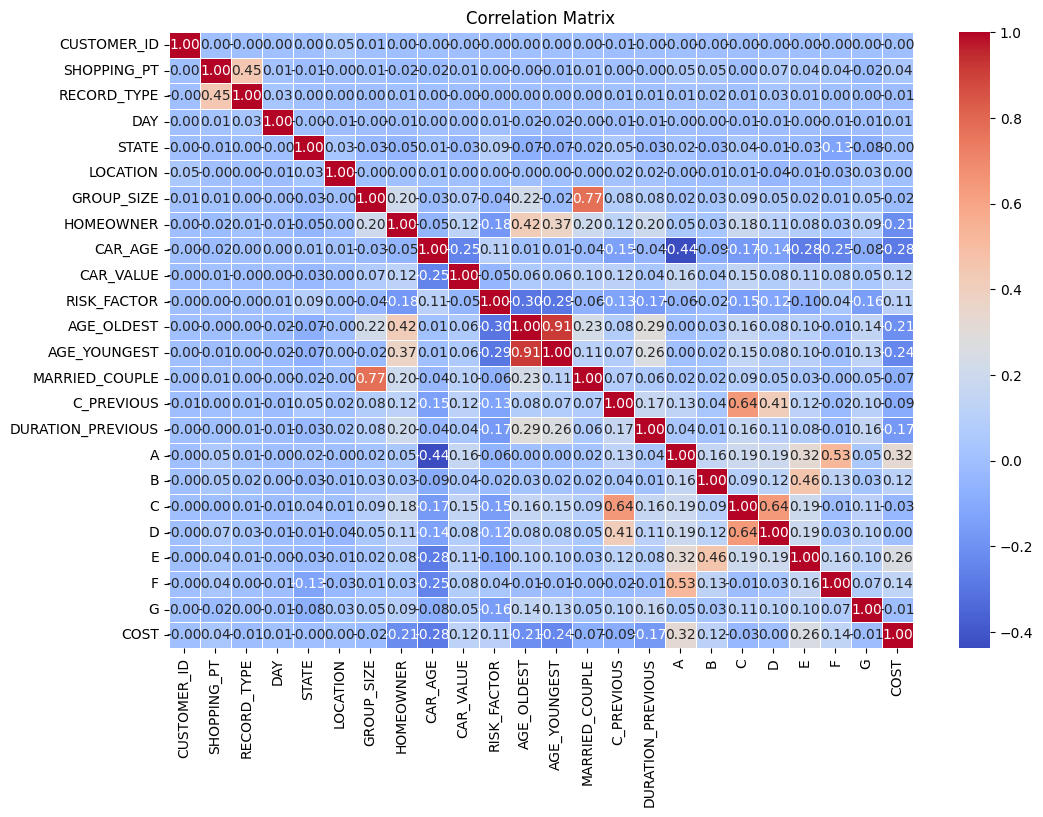

In [40]:
# Bivariate analysis: Correlation matrix and heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(['TIME'], axis =1).corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

###Preprocessed csv

In [5]:
df = pd.read_csv('/content/preprocessed_data.csv')

In [ ]:
# df= df.drop('Cluster',axis =1)

In [6]:
df.shape

(642634, 25)

In [9]:
df.head(10)

,CUSTOMER_ID,SHOPPING_PT,RECORD_TYPE,DAY,TIME,STATE,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,...,C_PREVIOUS,DURATION_PREVIOUS,A,B,C,D,E,F,G,COST
0,10000000,1,0.0,0.0,08:35:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,2.0,633
1,10000000,2,0.0,0.0,08:38:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
2,10000000,3,0.0,0.0,08:38:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
3,10000000,4,0.0,0.0,08:39:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
4,10000000,5,0.0,0.0,11:55:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,630
5,10000000,6,0.0,0.0,11:57:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,638
6,10000000,7,0.0,0.0,11:58:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,638
7,10000000,8,0.0,0.0,12:03:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,638
8,10000000,9,1.0,0.0,12:07:00,11,10001.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,634
9,10000005,1,0.0,3.0,08:56:00,24,10006.0,1.0,0.0,10.0,...,3.0,13.0,1.0,1.0,3.0,3.0,1.0,0.0,2.0,755


Encoding

In [55]:
# # Assuming df is your DataFrame
# categorical_features = ['STATE']
# print(categorical_features)
# # Label encoding
# label_encoder = LabelEncoder()
# for col in categorical_features:
#     df[col] = label_encoder.fit_transform(df[col])



###Train-test split

In [39]:
# Define target variable
target = 'COST'

# Train-test split
X = df.drop(columns=[target,'TIME','CUSTOMER_ID'])
#X = X.dropna()
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X.isnull().sum()

SHOPPING_PT          0
RECORD_TYPE          0
DAY                  0
STATE                0
LOCATION             0
GROUP_SIZE           0
HOMEOWNER            0
CAR_AGE              0
CAR_VALUE            0
RISK_FACTOR          0
AGE_OLDEST           0
AGE_YOUNGEST         0
MARRIED_COUPLE       0
C_PREVIOUS           0
DURATION_PREVIOUS    0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
dtype: int64

Scaling

In [41]:
# Columns to scale
columns_to_scale = ['CAR_AGE', 'AGE_OLDEST']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training set and transform both training and testing sets
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


In [42]:
X_train.head()

,SHOPPING_PT,RECORD_TYPE,DAY,STATE,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,CAR_VALUE,RISK_FACTOR,...,MARRIED_COUPLE,C_PREVIOUS,DURATION_PREVIOUS,A,B,C,D,E,F,G
3390,3,0.0,3.0,7,10757.0,1.0,0.0,0.035294,4,3.0,...,0.0,2.0,7.0,1.0,1.0,2.0,3.0,1.0,2.0,4.0
276569,3,0.0,0.0,33,12745.0,1.0,0.0,0.152941,4,3.0,...,0.0,2.0,3.0,0.0,0.0,2.0,3.0,0.0,0.0,2.0
451449,1,0.0,3.0,28,11845.0,1.0,1.0,0.094118,5,3.0,...,0.0,2.0,15.0,1.0,1.0,2.0,3.0,1.0,2.0,2.0
247943,1,0.0,2.0,23,10051.0,1.0,0.0,0.082353,6,3.0,...,1.0,1.0,9.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0
190863,1,0.0,2.0,28,10684.0,1.0,0.0,0.164706,7,4.0,...,0.0,3.0,1.0,1.0,0.0,3.0,3.0,1.0,2.0,4.0


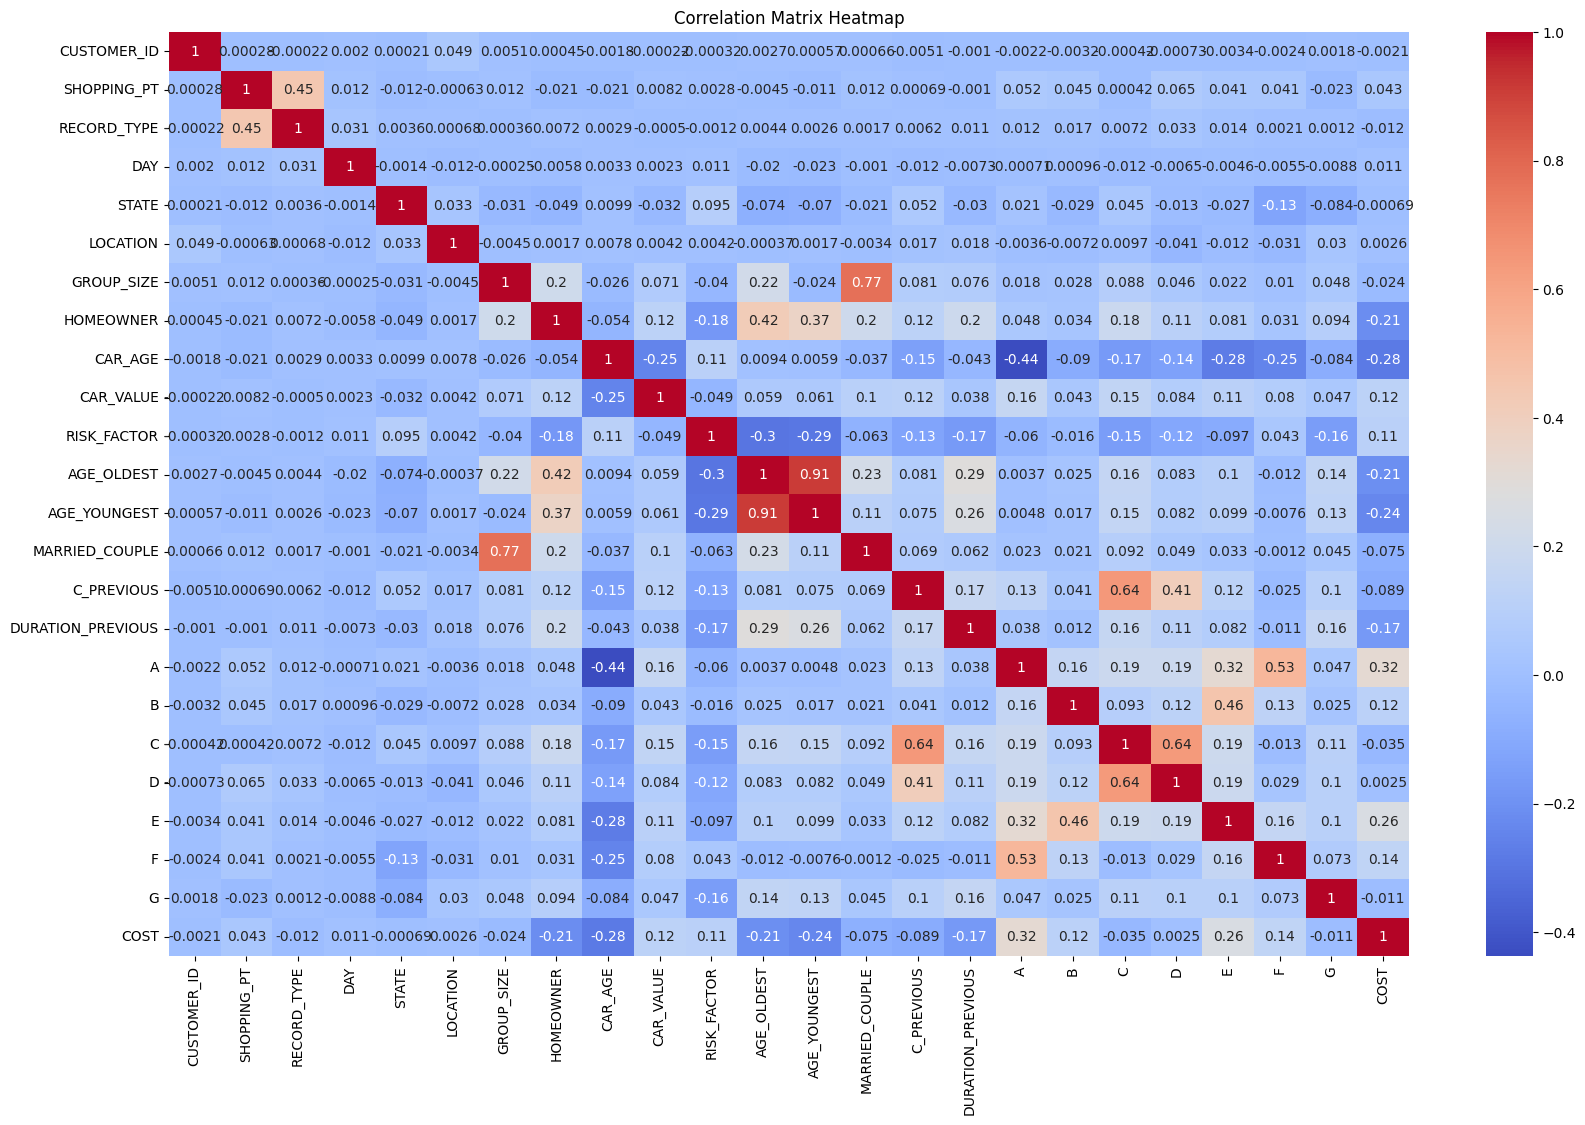

In [43]:
# Correlation Matrix with Heatmap
corr_matrix = df.drop('TIME',axis=1).corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


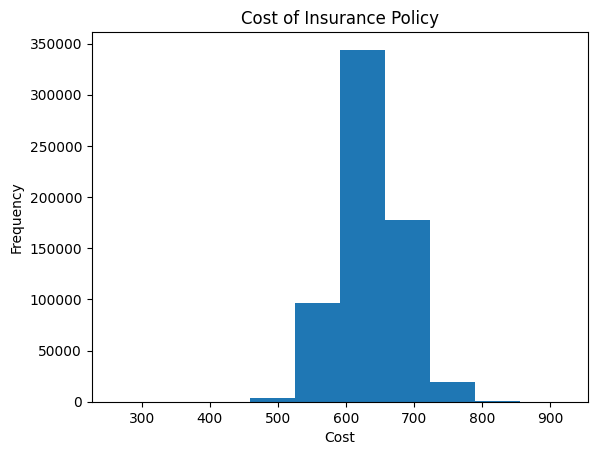

In [44]:
plt.hist(df['COST']); plt.title('Cost of Insurance Policy')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

###PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler

# Columns to scale
columns_to_scale = ['CAR_AGE', 'AGE_YOUNGEST', 'AGE_OLDEST']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training set and transform both training and testing sets
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# Apply PCA
n_components = 5  # Number of principal components to keep
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Print the explained variance ratio of each principal component
print(f"Explained variance ratio of each principal component: {pca.explained_variance_ratio_}")

# Create a DataFrame with the principal components
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])


Explained variance ratio of each principal component: [9.98743280e-01 1.25664800e-03 5.25575801e-08 1.13838333e-08
 2.84460252e-09]


In [ ]:
# Split the PCA-transformed data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_df, y, test_size=0.2, random_state=42)

# Initialize results dictionary
results = {}

# Train and evaluate each model using the PCA components
for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train_pca, y_train_pca)

    # Make predictions on the test data
    y_pred = model.predict(X_test_pca)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_pca, y_pred)
    mse = mean_squared_error(y_test_pca, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_pca, y_pred)

    # Store the results
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T  # Transpose for better formatting

# Print the results
print(results_df)

# Save results to a CSV file
results_df.to_csv('model_evaluation_results_pca.csv', index=True)


                         MAE          MSE       RMSE        R2
Linear Regression  35.520067  2035.171326  45.112873  0.031510
Ridge Regression   35.520067  2035.171327  45.112873  0.031510
Lasso Regression   35.528063  2035.493082  45.116439  0.031357
Decision Tree      17.930038  1139.838353  33.761492  0.457578
Random Forest      15.399494   547.877933  23.406792  0.739278
Gradient Boosting  32.745408  1739.780297  41.710674  0.172079


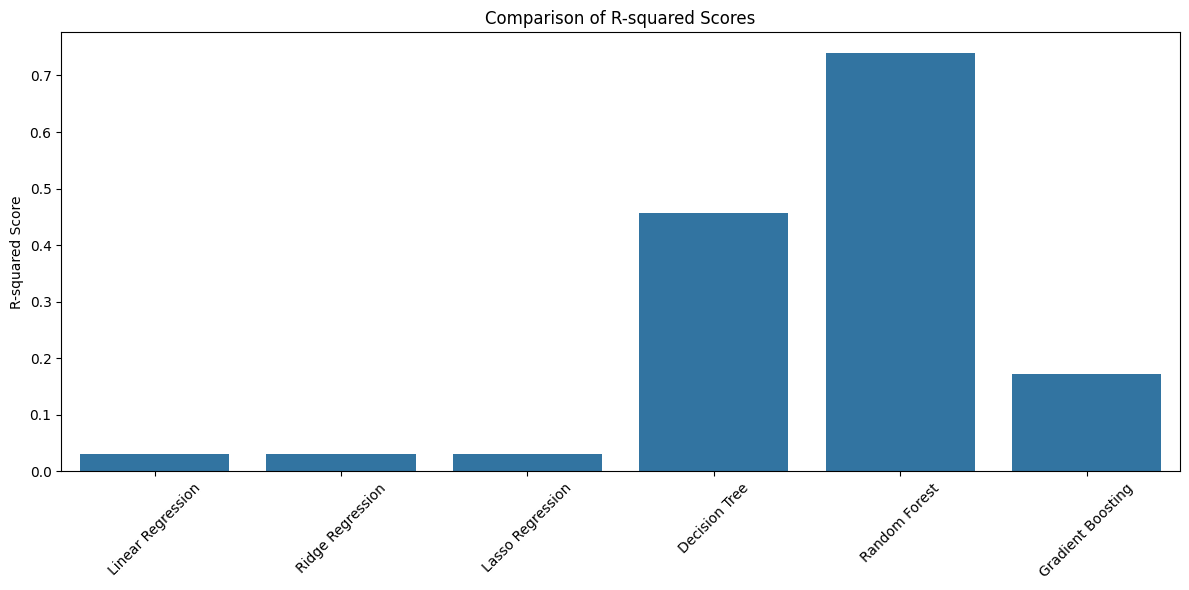

In [ ]:
# Plot comparison of R2 scores
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]
sns.barplot(x=model_names, y=r2_scores)
plt.title('Comparison of R-squared Scores')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###K-best, 13 features

In [ ]:
from sklearn.feature_selection import SelectKBest
# Univariate Selection
select_kbest = SelectKBest(score_func=f_regression, k=13)
fit = select_kbest.fit(X, y)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': fit.scores_})
print("Univariate Selection:")
print(feature_scores.nlargest(13, 'Score'))



Univariate Selection:
              Feature         Score
14                  A  75782.344962
6             CAR_AGE  55166.985914
18                  E  45774.180075
10       AGE_YOUNGEST  38812.664041
5           HOMEOWNER  30646.654580
9          AGE_OLDEST  29720.053681
13  DURATION_PREVIOUS  18761.550429
19                  F  12950.854488
7           CAR_VALUE   9335.883273
15                  B   9069.051114
8         RISK_FACTOR   7607.507574
12         C_PREVIOUS   5186.179561
11     MARRIED_COUPLE   3620.120444


In [ ]:
# Univariate Selection
select_kbest = SelectKBest(score_func=f_regression, k=13)
fit = select_kbest.fit(X, y)
selected_features = X.columns[fit.get_support()]
print(f"Selected features from Univariate Selection: {selected_features}")

# Subset the data with selected features
X_selected = X[selected_features]

Selected features from Univariate Selection: Index(['HOMEOWNER', 'CAR_AGE', 'CAR_VALUE', 'RISK_FACTOR', 'AGE_OLDEST',
       'AGE_YOUNGEST', 'MARRIED_COUPLE', 'C_PREVIOUS', 'DURATION_PREVIOUS',
       'A', 'B', 'E', 'F'],
      dtype='object')


In [ ]:
# Subset the data with selected features
X_selected = X[selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [ ]:


# # Feature Importance from Random Forest
# model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rf.fit(X, y)
# importances = model_rf.feature_importances_
# feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# print("\nFeature Importance from Random Forest:")
# print(feature_importances.sort_values(by='Importance', ascending=False))

# # Lasso Regularization (L1 Regularization)
# model_lasso = Lasso(alpha=0.01)
# model_lasso.fit(X, y)
# lasso_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': model_lasso.coef_})
# print("\nLasso Regularization:")
# print(lasso_coef[lasso_coef['Coefficient'] != 0])


In [ ]:
# with pd.option_context('display.max_columns', None):
#   print(X_train.head(25))

In [ ]:
# Models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}



In [ ]:


# Initialize results dictionary
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }



In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results).T  # Transpose for better formatting

# Save results to a CSV file
results_df.to_csv('model_evaluation_results_kbest_final.csv', index=True)

# Display the results as a table
results_df

,MAE,MSE,RMSE,R2
Linear Regression,30.314333,1497.283486,38.694748,0.287478
Ridge Regression,30.314333,1497.283467,38.694747,0.287478
Lasso Regression,30.610044,1522.968185,39.025225,0.275255
Decision Tree,10.826321,461.819265,21.489981,0.780231
Random Forest,10.387793,324.975716,18.027083,0.845352
Gradient Boosting,27.999386,1285.729983,35.857077,0.388151


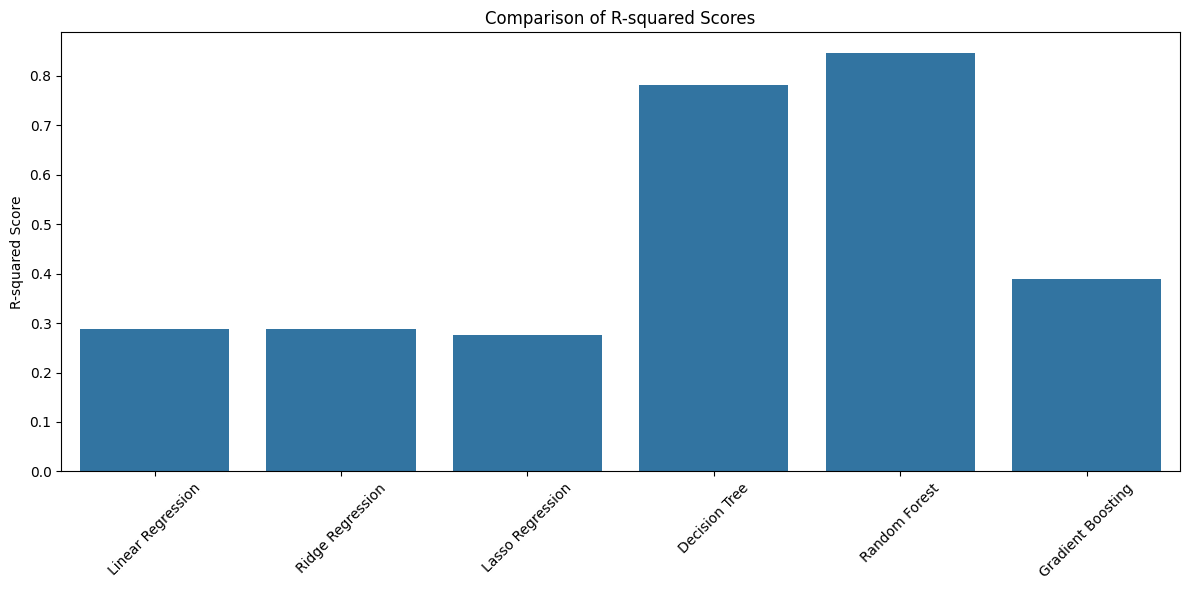

In [ ]:
# Plot comparison of R2 scores
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]
sns.barplot(x=model_names, y=r2_scores)
plt.title('Comparison of R-squared Scores')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Fit the best model (Random Forest in this case) on the entire training data
best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)

# Predictions and evaluation on the training set
train_predictions = best_model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_predictions)

print(f"Train Set Evaluation for Random Forest:")
print(f"  MAE: {train_mae}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")
print(f"  R2: {train_r2}")

# Predictions and evaluation on the test set
test_predictions = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print(f"\nTest Set Evaluation for Random Forest:")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R2: {test_r2}")

Train Set Evaluation for Random Forest:
  MAE: 6.162253697948727
  MSE: 109.77073855151068
  RMSE: 10.47715317018467
  R2: 0.9482636536821321

Test Set Evaluation for Random Forest:
  MAE: 10.384271728720485
  MSE: 324.7069745298577
  RMSE: 18.019627480329824
  R2: 0.8454795844437749


In [ ]:
# Create DataFrame with features, actual and predicted values for test set
test_results = pd.DataFrame(X_test, columns=columns_to_scale)
test_results['Actual'] = y_test.values
test_results['Predicted'] = test_predictions

print("\nSample of Test Results:")
print(test_results.head())


Sample of Test Results:
        CAR_AGE  AGE_YOUNGEST  AGE_OLDEST  Actual   Predicted
372645      1.0          59.0        59.0     725  703.900455
389686     14.0          33.0        33.0     612  612.320000
330268      1.0          21.0        21.0     640  642.105357
161533      5.0          35.0        35.0     637  637.345000
639331     16.0          45.0        45.0     633  632.441143


In [ ]:
# Compare metrics between train and test sets
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Train': [train_mae, train_mse, train_rmse, train_r2],
    'Test': [test_mae, test_mse, test_rmse, test_r2]
})

# Save results to a CSV file
metrics_comparison.to_csv('best_model_metrics.csv', index=True)
print("\nMetrics Comparison:")
metrics_comparison


Metrics Comparison:


,Metric,Train,Test
0,MAE,6.162254,10.384272
1,MSE,109.770739,324.706975
2,RMSE,10.477153,18.019627
3,R2,0.948264,0.845480


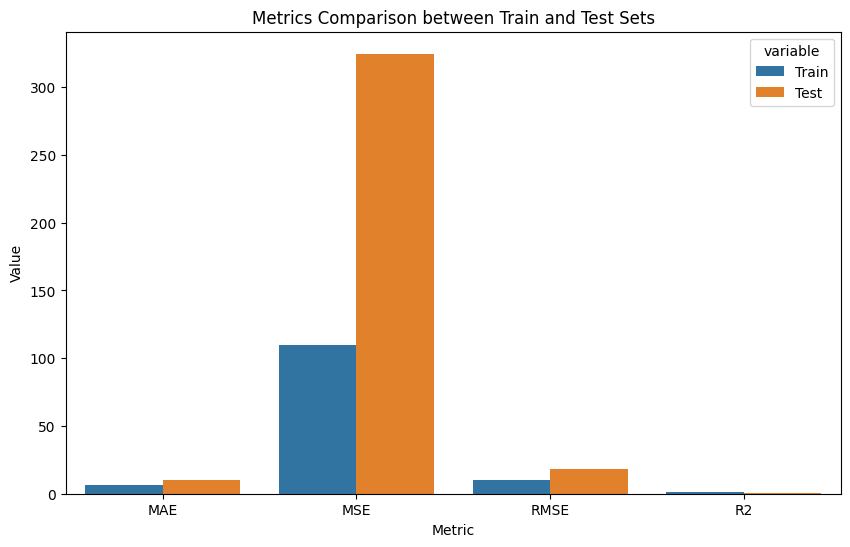

In [ ]:

# Visualize the metrics comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='value', hue='variable', data=pd.melt(metrics_comparison, ['Metric']))
plt.title('Metrics Comparison between Train and Test Sets')
plt.ylabel('Value')
plt.show()

###Manual FS , 15 features

In [63]:
selected_features = ['RECORD_TYPE','STATE','GROUP_SIZE','HOMEOWNER','CAR_AGE','CAR_VALUE','RISK_FACTOR',
                     'MARRIED_COUPLE','AGE_OLDEST','DURATION_PREVIOUS', 'A' ,'B','C','E' ,'G']

In [62]:
len(selected_features)

16

In [64]:
    # Define target variable
target = 'COST'
# Subset the data with selected features
X_selected = df[selected_features]
y = df[target]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)



In [65]:
X_selected.duplicated().sum()

332131

In [67]:
X_selected.drop_duplicates(inplace=True)

<ipython-input-67-db15456561a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected.drop_duplicates(inplace=True)


In [43]:
X_selected.head()

,RECORD_TYPE,STATE,GROUP_SIZE,HOMEOWNER,CAR_AGE,CAR_VALUE,RISK_FACTOR,MARRIED_COUPLE,AGE_OLDEST,C_PREVIOUS,DURATION_PREVIOUS,A,C,E,G
0,0.0,11,2.0,0.0,2.0,6,3.0,1.0,46.0,1.0,2.0,1.0,2.0,1.0,2.0
1,0.0,11,2.0,0.0,2.0,6,3.0,1.0,46.0,1.0,2.0,1.0,2.0,1.0,1.0
2,0.0,11,2.0,0.0,2.0,6,3.0,1.0,46.0,1.0,2.0,1.0,2.0,1.0,1.0
3,0.0,11,2.0,0.0,2.0,6,3.0,1.0,46.0,1.0,2.0,1.0,2.0,1.0,1.0
4,0.0,11,2.0,0.0,2.0,6,3.0,1.0,46.0,1.0,2.0,1.0,2.0,1.0,1.0


In [44]:
# # Columns to scale
# columns_to_scale = ['CAR_AGE', 'AGE_OLDEST']

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler on the training set and transform both training and testing sets
# X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
# X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


In [ ]:
X.columns

Index(['RECORD_TYPE', 'DAY', 'STATE', 'LOCATION', 'GROUP_SIZE', 'HOMEOWNER',
       'CAR_AGE', 'CAR_VALUE', 'RISK_FACTOR', 'AGE_OLDEST', 'AGE_YOUNGEST',
       'MARRIED_COUPLE', 'C_PREVIOUS', 'DURATION_PREVIOUS', 'A', 'B', 'C', 'D',
       'E', 'F', 'G'],
      dtype='object')

In [66]:
# Fit the best model (Random Forest in this case) on the entire training data
best_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
best_model.fit(X_train, y_train)

# Predictions and evaluation on the training set
train_predictions = best_model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_predictions)

print(f"Train Set Evaluation for Random Forest:")
print(f"  MAE: {train_mae}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")
print(f"  R2: {train_r2}")

# Predictions and evaluation on the test set
test_predictions = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print(f"\nTest Set Evaluation for Random Forest:")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R2: {test_r2}")

Train Set Evaluation for Random Forest:
  MAE: 4.694547437038672
  MSE: 63.03326167805324
  RMSE: 7.939348945477409
  R2: 0.9702916214398042

Test Set Evaluation for Random Forest:
  MAE: 9.47583718480117
  MSE: 268.60722682930964
  RMSE: 16.389241191382524
  R2: 0.8721761355105921


In [58]:
# Create DataFrame with features, actual and predicted values for test set
test_results = pd.DataFrame(X_test, columns=selected_features)
test_results['Actual'] = y_test.values
test_results['Predicted'] = test_predictions

print("\nSample of Test Results:")
print(test_results.head())


Sample of Test Results:
        RECORD_TYPE  STATE  GROUP_SIZE  HOMEOWNER  CAR_AGE  CAR_VALUE  \
571173          0.0     24         1.0        0.0      1.0          6   
596924          0.0     11         1.0        0.0     14.0          4   
506952          0.0     24         1.0        0.0      1.0          4   
247887          0.0     24         1.0        0.0      5.0          5   
633051          0.0     23         1.0        1.0     16.0          4   

        RISK_FACTOR  MARRIED_COUPLE  AGE_OLDEST  C_PREVIOUS  \
571173          4.0             0.0        59.0         3.0   
596924          3.0             0.0        33.0         1.0   
506952          2.0             0.0        21.0         3.0   
247887          1.0             0.0        35.0         2.0   
633051          4.0             0.0        45.0         1.0   

        DURATION_PREVIOUS    A    B    C    E    G  Actual   Predicted  
571173                7.0  1.0  1.0  3.0  1.0  4.0     725  692.694524  
596924     

In [59]:
# Compare metrics between train and test sets
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Train': [train_mae, train_mse, train_rmse, train_r2],
    'Test': [test_mae, test_mse, test_rmse, test_r2]
})

# Save results to a CSV file
metrics_comparison.to_csv('best_model_metrics_trial02.csv', index=True)
print("\nMetrics Comparison:")
metrics_comparison


Metrics Comparison:


,Metric,Train,Test
0,MAE,4.550051,9.132030
1,MSE,59.463034,248.835703
2,RMSE,7.711228,15.774527
3,R2,0.971974,0.881585


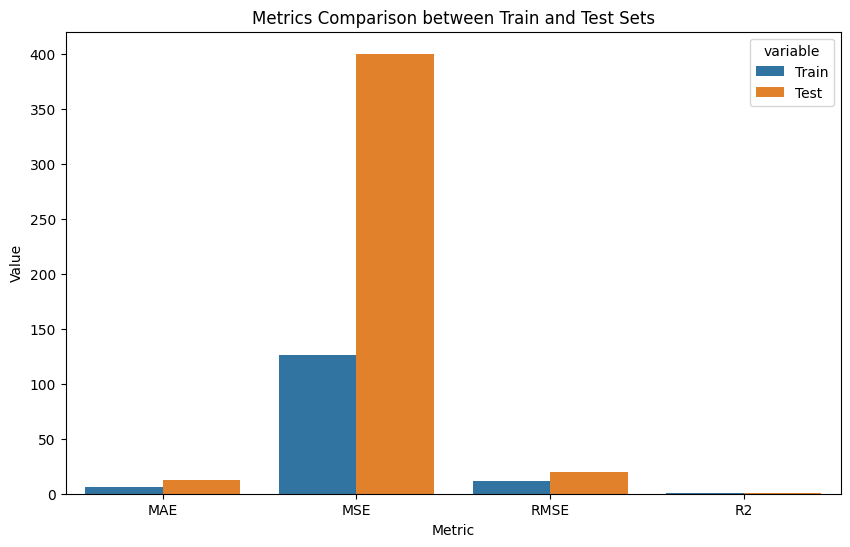

In [ ]:

# Visualize the metrics comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='value', hue='variable', data=pd.melt(metrics_comparison, ['Metric']))
plt.title('Metrics Comparison between Train and Test Sets')
plt.ylabel('Value')
plt.show()

###RFR - hyperparameter tuning

In [68]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [69]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor()

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [ ]:
# Create the randomized search cross-validation object
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit on the training data
rf_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters found:")
print(rf_random.best_params_)
print("\nBest Score found:")
print(rf_random.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
# 5. Evaluate on training set
train_predictions = rf_random.best_estimator_.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_predictions)

print(f"Train Set Evaluation for Random Forest:")
print(f"  MAE: {train_mae}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")
print(f"  R2: {train_r2}")

In [ ]:
# Evaluate on validation set
val_predictions = rf_random.best_estimator_.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_predictions)

print(f"Validation Set Evaluation for Random Forest:")
print(f"  MAE: {val_mae}")
print(f"  MSE: {val_mse}")
print(f"  RMSE: {val_rmse}")
print(f"  R2: {val_r2}")


In [ ]:
# Predictions and evaluation on the test set
test_predictions = rf_random.best_estimator_.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print(f"\nTest Set Evaluation for Random Forest (after tuning):")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R2: {test_r2}")


In [ ]:
import pandas as pd

# Assuming you have metrics variables defined (e.g., val_mae, val_mse, etc.)

# Create a DataFrame with metrics results
metrics_results = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Training': [train_mae, train_mse, train_rmse, train_r2],
    'Validation': [val_mae, val_mse, val_rmse, val_r2],
    'Test': [test_mae, test_mse, test_rmse, test_r2]
})

# Save metrics results to CSV
metrics_results.to_csv('metrics_results_hyperparam.csv', index=False)

print("Metrics results saved successfully.")


###K-best , 18 features

In [ ]:
# Univariate Selection
select_kbest = SelectKBest(score_func=f_regression, k=18)
fit = select_kbest.fit(X, y)
selected_features = X.columns[fit.get_support()]
print(f"Selected features from Univariate Selection: {selected_features}")

# Subset the data with selected features
X_selected = X[selected_features]

Selected features from Univariate Selection: Index(['SHOPPING_PT', 'RECORD_TYPE', 'GROUP_SIZE', 'HOMEOWNER', 'CAR_AGE',
       'CAR_VALUE', 'RISK_FACTOR', 'AGE_OLDEST', 'AGE_YOUNGEST',
       'MARRIED_COUPLE', 'C_PREVIOUS', 'DURATION_PREVIOUS', 'A', 'B', 'C', 'E',
       'F', 'G'],
      dtype='object')


In [ ]:
# Subset the data with selected features
X_selected = X[selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [ ]:


# # Feature Importance from Random Forest
# model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rf.fit(X, y)
# importances = model_rf.feature_importances_
# feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# print("\nFeature Importance from Random Forest:")
# print(feature_importances.sort_values(by='Importance', ascending=False))

# # Lasso Regularization (L1 Regularization)
# model_lasso = Lasso(alpha=0.01)
# model_lasso.fit(X, y)
# lasso_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': model_lasso.coef_})
# print("\nLasso Regularization:")
# print(lasso_coef[lasso_coef['Coefficient'] != 0])


In [ ]:
# with pd.option_context('display.max_columns', None):
#   print(X_train.head(25))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize results dictionary
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }



In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results).T  # Transpose for better formatting

# Save results to a CSV file
results_df.to_csv('model_evaluation_results_kbest_18.csv', index=True)

# Display the results as a table
results_df

,MAE,MSE,RMSE,R2
Linear Regression,30.287037,1494.874226,38.663603,0.288624
Ridge Regression,30.287037,1494.874210,38.663603,0.288625
Lasso Regression,30.601997,1522.496737,39.019184,0.275480
Decision Tree,12.501943,667.345682,25.833035,0.682426
Random Forest,11.178595,347.363800,18.637698,0.834698
Gradient Boosting,27.704420,1259.923777,35.495405,0.400432


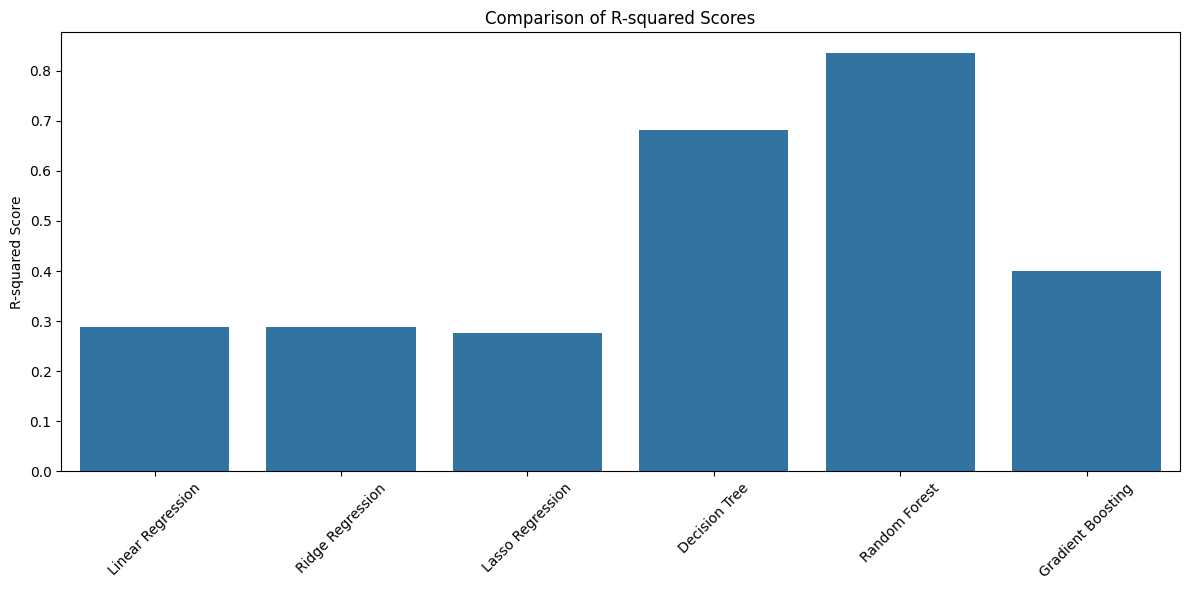

In [ ]:
# Plot comparison of R2 scores
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]
sns.barplot(x=model_names, y=r2_scores)
plt.title('Comparison of R-squared Scores')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# # Fit the best model (Random Forest in this case) on the entire training data
# best_model = RandomForestRegressor()
# best_model.fit(X_train, y_train)

# # Predictions and evaluation on the test set
# test_predictions = best_model.predict(X_test)
# test_mae = mean_absolute_error(y_test, test_predictions)
# test_mse = mean_squared_error(y_test, test_predictions)
# test_rmse = np.sqrt(test_mse)
# test_r2 = r2_score(y_test, test_predictions)

# print(f"Test Set Evaluation for Random Forest:")
# print(f"  MAE: {test_mae}")
# print(f"  MSE: {test_mse}")
# print(f"  RMSE: {test_rmse}")
# print(f"  R2: {test_r2}")

# # Create DataFrame with features, actual and predicted values for test set
# test_results = pd.DataFrame(X_test, columns=columns_to_scale)
# test_results['Actual'] = y_test.values
# test_results['Predicted'] = test_predictions

# print("\nSample of Test Results:")
# print(test_results.head())


###RFE, 15 features

In [ ]:
# Recursive Feature Elimination (RFE)
model_lr = LinearRegression()
rfe = RFE(model_lr, n_features_to_select=15)
fit = rfe.fit(X, y)
selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': fit.support_, 'Ranking': fit.ranking_})
print("\nRecursive Feature Elimination:")
print(selected_features[selected_features['Selected'] == True])


Recursive Feature Elimination:
              Feature  Selected  Ranking
1         SHOPPING_PT      True        1
2         RECORD_TYPE      True        1
6          GROUP_SIZE      True        1
7           HOMEOWNER      True        1
8             CAR_AGE      True        1
9           CAR_VALUE      True        1
10        RISK_FACTOR      True        1
13     MARRIED_COUPLE      True        1
14         C_PREVIOUS      True        1
15  DURATION_PREVIOUS      True        1
16                  A      True        1
19                  D      True        1
20                  E      True        1
21                  F      True        1
22                  G      True        1


In [ ]:
# Extract the names of the selected features
selected_feature_names = selected_features[selected_features['Selected'] == True]['Feature'].tolist()


In [ ]:
# Subset the data with selected features
X_selected = X[selected_feature_names]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [ ]:


# # Feature Importance from Random Forest
# model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rf.fit(X, y)
# importances = model_rf.feature_importances_
# feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# print("\nFeature Importance from Random Forest:")
# print(feature_importances.sort_values(by='Importance', ascending=False))

# # Lasso Regularization (L1 Regularization)
# model_lasso = Lasso(alpha=0.01)
# model_lasso.fit(X, y)
# lasso_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': model_lasso.coef_})
# print("\nLasso Regularization:")
# print(lasso_coef[lasso_coef['Coefficient'] != 0])


In [ ]:
# with pd.option_context('display.max_columns', None):
#   print(X_train.head(25))

        CUSTOMER_ID  SHOPPING_PT  RECORD_TYPE  DAY  STATE  LOCATION  \
2182       10000827            3          0.0  3.0      7   10757.0   
515779     10065989            3          0.0  0.0     33   12745.0   
294545     10107417            1          0.0  3.0     28   11845.0   
505980     10059264            1          0.0  2.0     23   10051.0   
486224     10045685            1          0.0  2.0     28   10684.0   
52378      10019414            8          1.0  2.0      7   11757.0   
259684     10094616            3          1.0  4.0      7   10670.0   
569680     10102792            7          0.0  1.0     13   12356.0   
103489     10038075            7          0.0  2.0     24   13033.0   
173991     10063667            2          0.0  3.0     11   14178.0   
168142     10061511            7          0.0  3.0      7   11318.0   
585319     10113225            1          0.0  3.0     28   11025.0   
474685     10037953            4          0.0  3.0     31   10237.0   
74932 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize results dictionary
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }



In [ ]:
# Convert results to a DataFrame
results_df_rfe = pd.DataFrame(results).T  # Transpose for better formatting

# Save results to a CSV file
results_df_rfe.to_csv('model_evaluation_results_rfe.csv', index=True)

# Display the results as a table
results_df_rfe

,MAE,MSE,RMSE,R2
Linear Regression,30.702368,1532.580308,39.148184,0.270681
Ridge Regression,30.702369,1532.580301,39.148184,0.270681
Lasso Regression,31.115393,1570.174419,39.625426,0.252791
Decision Tree,17.066289,1012.875614,31.825707,0.517996
Random Forest,15.526696,575.660175,23.992919,0.726057
Gradient Boosting,28.668779,1345.024708,36.674578,0.359934


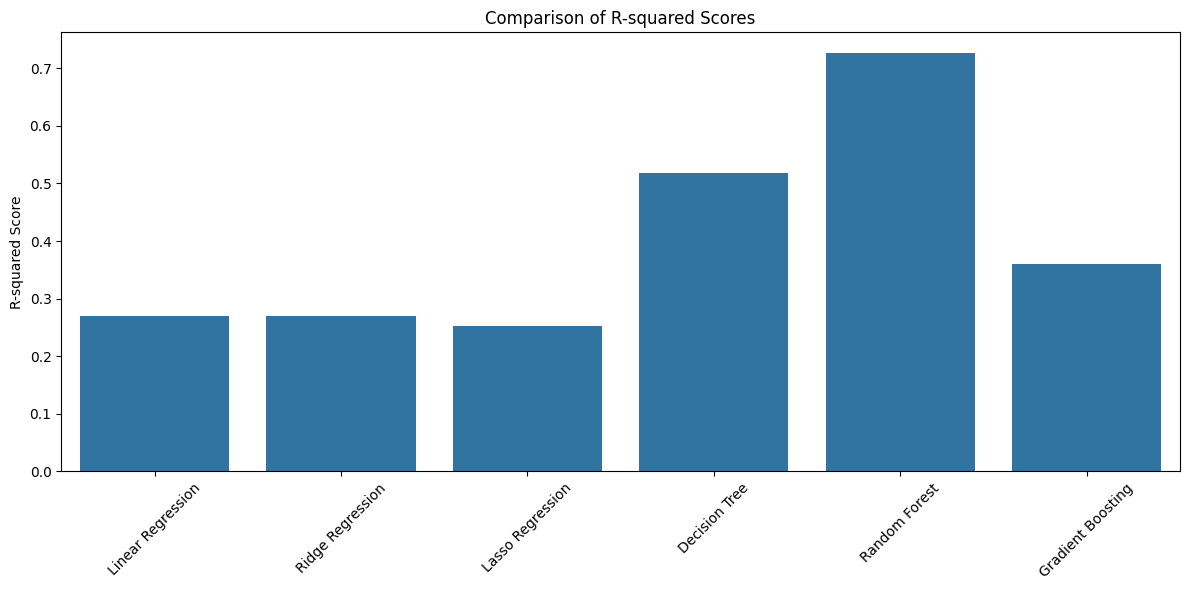

In [ ]:
# Plot comparison of R2 scores
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]
sns.barplot(x=model_names, y=r2_scores)
plt.title('Comparison of R-squared Scores')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Fit the best model (Random Forest in this case) on the entire training data
best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)

# Predictions and evaluation on the test set
test_predictions = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test Set Evaluation for Random Forest:")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R2: {test_r2}")

# Create DataFrame with features, actual and predicted values for test set
test_results = pd.DataFrame(X_test, columns=columns_to_scale)
test_results['Actual'] = y_test.values
test_results['Predicted'] = test_predictions

print("\nSample of Test Results:")
print(test_results.head())


###RFE , 18 features

In [ ]:
# Recursive Feature Elimination (RFE)
model_lr = LinearRegression()
rfe = RFE(model_lr, n_features_to_select=18)
fit = rfe.fit(X, y)
selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': fit.support_, 'Ranking': fit.ranking_})
print("\nRecursive Feature Elimination:")
print(selected_features[selected_features['Selected'] == True])


Recursive Feature Elimination:
              Feature  Selected  Ranking
1         SHOPPING_PT      True        1
2         RECORD_TYPE      True        1
6          GROUP_SIZE      True        1
7           HOMEOWNER      True        1
8             CAR_AGE      True        1
9           CAR_VALUE      True        1
10        RISK_FACTOR      True        1
11         AGE_OLDEST      True        1
12       AGE_YOUNGEST      True        1
13     MARRIED_COUPLE      True        1
14         C_PREVIOUS      True        1
15  DURATION_PREVIOUS      True        1
16                  A      True        1
17                  B      True        1
19                  D      True        1
20                  E      True        1
21                  F      True        1
22                  G      True        1


In [ ]:
# Extract the names of the selected features
selected_feature_names = selected_features[selected_features['Selected'] == True]['Feature'].tolist()


In [ ]:
# Subset the data with selected features
X_selected = X[selected_feature_names]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [ ]:


# # Feature Importance from Random Forest
# model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rf.fit(X, y)
# importances = model_rf.feature_importances_
# feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# print("\nFeature Importance from Random Forest:")
# print(feature_importances.sort_values(by='Importance', ascending=False))

# # Lasso Regularization (L1 Regularization)
# model_lasso = Lasso(alpha=0.01)
# model_lasso.fit(X, y)
# lasso_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': model_lasso.coef_})
# print("\nLasso Regularization:")
# print(lasso_coef[lasso_coef['Coefficient'] != 0])


In [ ]:
# with pd.option_context('display.max_columns', None):
#   print(X_train.head(25))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize results dictionary
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }



In [ ]:
# Convert results to a DataFrame
results_df_rfe = pd.DataFrame(results).T  # Transpose for better formatting

# Save results to a CSV file
results_df_rfe.to_csv('model_evaluation_results_rfe_18.csv', index=True)

# Display the results as a table
results_df_rfe

,MAE,MSE,RMSE,R2
Linear Regression,30.279702,1494.636066,38.660523,0.288738
Ridge Regression,30.279702,1494.636050,38.660523,0.288738
Lasso Regression,30.601997,1522.496737,39.019184,0.275480
Decision Tree,12.423655,656.191166,25.616229,0.687734
Random Forest,11.090205,342.430231,18.504870,0.837046
Gradient Boosting,27.739385,1261.809017,35.521951,0.399535


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


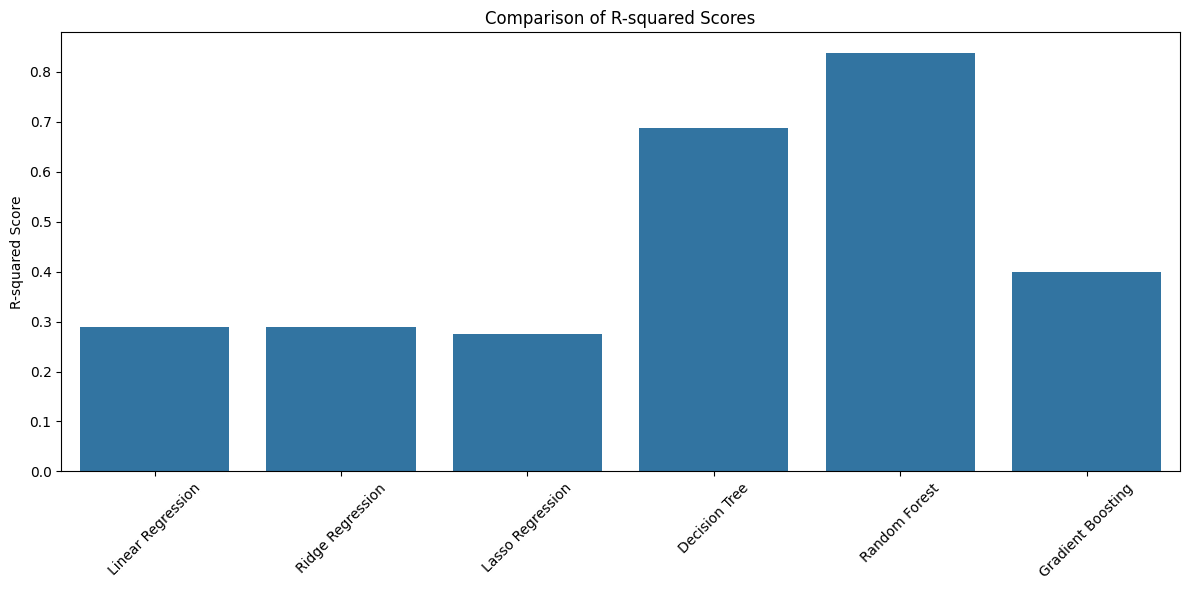

In [ ]:
# Plot comparison of R2 scores
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
r2_scores = [results[name]['R2'] for name in model_names]
sns.barplot(x=model_names, y=r2_scores)
plt.title('Comparison of R-squared Scores')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# # Fit the best model (Random Forest in this case) on the entire training data
# best_model = RandomForestRegressor()
# best_model.fit(X_train, y_train)

# # Predictions and evaluation on the test set
# test_predictions = best_model.predict(X_test)
# test_mae = mean_absolute_error(y_test, test_predictions)
# test_mse = mean_squared_error(y_test, test_predictions)
# test_rmse = np.sqrt(test_mse)
# test_r2 = r2_score(y_test, test_predictions)

# print(f"Test Set Evaluation for Random Forest:")
# print(f"  MAE: {test_mae}")
# print(f"  MSE: {test_mse}")
# print(f"  RMSE: {test_rmse}")
# print(f"  R2: {test_r2}")

# # Create DataFrame with features, actual and predicted values for test set
# test_results = pd.DataFrame(X_test, columns=columns_to_scale)
# test_results['Actual'] = y_test.values
# test_results['Predicted'] = test_predictions

# print("\nSample of Test Results:")
# print(test_results.head())


###Extra

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# # Function to evaluate model and return metrics
# def evaluate_model(model, X_train, X_test, y_train, y_test):
#     # Predictions
#     train_predictions = model.predict(X_train)
#     test_predictions = model.predict(X_test)

#     # MAE, MSE, RMSE, R2 for training set
#     train_mae = mean_absolute_error(y_train, train_predictions)
#     train_mse = mean_squared_error(y_train, train_predictions)
#     train_rmse = np.sqrt(train_mse)
#     train_r2 = r2_score(y_train, train_predictions)

#     # MAE, MSE, RMSE, R2 for test set
#     test_mae = mean_absolute_error(y_test, test_predictions)
#     test_mse = mean_squared_error(y_test, test_predictions)
#     test_rmse = np.sqrt(test_mse)
#     test_r2 = r2_score(y_test, test_predictions)

#     return train_mae, train_mse, train_rmse, train_r2, test_mae, test_mse, test_rmse, test_r2


In [ ]:
# # Evaluate Linear Regression model
# lr_train_mae, lr_train_mse, lr_train_rmse, lr_train_r2, lr_test_mae, lr_test_mse, lr_test_rmse, lr_test_r2 = \
#     evaluate_model(lr_model, X_train, X_test, y_train, y_test)

# # Evaluate Random Forest model
# rf_train_mae, rf_train_mse, rf_train_rmse, rf_train_r2, rf_test_mae, rf_test_mse, rf_test_rmse, rf_test_r2 = \
#     evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# # Print metrics for both models
# print("Linear Regression Metrics:")
# print(f"  Train MAE: {lr_train_mae}, MSE: {lr_train_mse}, RMSE: {lr_train_rmse}, R2: {lr_train_r2}")
# print(f"  Test MAE: {lr_test_mae}, MSE: {lr_test_mse}, RMSE: {lr_test_rmse}, R2: {lr_test_r2}")

# print("\nRandom Forest Metrics:")
# print(f"  Train MAE: {rf_train_mae}, MSE: {rf_train_mse}, RMSE: {rf_train_rmse}, R2: {rf_train_r2}")
# print(f"  Test MAE: {rf_test_mae}, MSE: {rf_test_mse}, RMSE: {rf_test_rmse}, R2: {rf_test_r2}")


Linear Regression Metrics:
  Train MAE: 28.673585010843397, MSE: 1388.665065696355, RMSE: 37.264796600764576, R2: 0.345504478639561
  Test MAE: 28.556728963998594, MSE: 1371.209707766663, RMSE: 37.02984887582804, R2: 0.3474735362071758

Random Forest Metrics:
  Train MAE: 2.4833989422435403, MSE: 16.094910777717477, RMSE: 4.011846305345891, R2: 0.9924142636832088
  Test MAE: 6.645857679709323, MSE: 111.51398097131343, RMSE: 10.560018038399056, R2: 0.9469331180675583


In [ ]:
X_test.columns.tolist()

['CUSTOMER_ID',
 'SHOPPING_PT',
 'RECORD_TYPE',
 'DAY',
 'STATE',
 'LOCATION',
 'GROUP_SIZE',
 'HOMEOWNER',
 'CAR_AGE',
 'CAR_VALUE',
 'RISK_FACTOR',
 'AGE_OLDEST',
 'AGE_YOUNGEST',
 'MARRIED_COUPLE',
 'C_PREVIOUS',
 'DURATION_PREVIOUS',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G']

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Function to evaluate model and return metrics and predictions
def evaluate_model(model, X_train, X_test, y_train, y_test, feature_names):
    # Predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # MAE, MSE, RMSE, R2 for training set
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, train_predictions)

    # MAE, MSE, RMSE, R2 for test set
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, test_predictions)

    # Create DataFrame with features, actual and predicted values for train and test sets
    train_results = pd.DataFrame(X_train, columns=feature_names)
    train_results['Actual'] = y_train
    train_results['Predicted'] = train_predictions

    test_results = pd.DataFrame(X_test, columns=feature_names)
    test_results['Actual'] = y_test
    test_results['Predicted'] = test_predictions

    return (train_mae, train_mse, train_rmse, train_r2, test_mae, test_mse, test_rmse, test_r2,
            train_results, test_results)

# Feature names
feature_names = X_train.columns.to_list()
#  ['HOMEOWNER', 'GROUP_SIZE', 'CAR_AGE', 'CAR_VALUE', 'AGE_OLDEST', 'AGE_YOUNGEST', 'MARRIED_COUPLE']

# Evaluate Linear Regression model
(lr_train_mae, lr_train_mse, lr_train_rmse, lr_train_r2, lr_test_mae, lr_test_mse, lr_test_rmse, lr_test_r2,
 lr_train_results, lr_test_results) = evaluate_model(lr_model, X_train, X_test, y_train, y_test, feature_names)

# Evaluate Random Forest model
(rf_train_mae, rf_train_mse, rf_train_rmse, rf_train_r2, rf_test_mae, rf_test_mse, rf_test_rmse, rf_test_r2,
 rf_train_results, rf_test_results) = evaluate_model(rf_model, X_train, X_test, y_train, y_test, feature_names)


In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import matplotlib.pyplot as plt
# import numpy as np

# def evaluate_model(model, X_train, X_test, y_train, y_test, feature_names):
#     # Fit the model
#     model.fit(X_train, y_train)

#     # Predictions
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     # Training metrics
#     train_mae = mean_absolute_error(y_train, y_train_pred)
#     train_mse = mean_squared_error(y_train, y_train_pred)
#     train_rmse = np.sqrt(train_mse)
#     train_r2 = r2_score(y_train, y_train_pred)

#     # Testing metrics
#     test_mae = mean_absolute_error(y_test, y_test_pred)
#     test_mse = mean_squared_error(y_test, y_test_pred)
#     test_rmse = np.sqrt(test_mse)
#     test_r2 = r2_score(y_test, y_test_pred)

#     # Collect results
#     train_results = pd.DataFrame({
#         'Actual': y_train,
#         'Predicted': y_train_pred,
#         'Feature Importance': feature_names
#     })

#     test_results = pd.DataFrame({
#         'Actual': y_test,
#         'Predicted': y_test_pred,
#         'Feature Importance': feature_names
#     })

#     return (train_mae, train_mse, train_rmse, train_r2, test_mae, test_mse, test_rmse, test_r2,
#             train_results, test_results)


In [ ]:
# # Define models to evaluate
# models = {
#     'Linear Regression': LinearRegression(),
#     'Ridge Regression': Ridge(),
#     'Lasso Regression': Lasso(),
#     'Decision Tree': DecisionTreeRegressor(),
#     'Random Forest': RandomForestRegressor(),
#     'Gradient Boosting': GradientBoostingRegressor()
# }

# # Initialize results storage
# model_metrics = {}
# r2_scores = []

# # Feature names
# feature_names = X_train.columns.tolist()

# # Evaluate each model
# for name, model in models.items():
#     (train_mae, train_mse, train_rmse, train_r2, test_mae, test_mse, test_rmse, test_r2,
#      train_results, test_results) = evaluate_model(model, X_train, X_test, y_train, y_test, feature_names)

#     # Store metrics
#     model_metrics[name] = {
#         'Train MAE': train_mae,
#         'Train MSE': train_mse,
#         'Train RMSE': train_rmse,
#         'Train R2': train_r2,
#         'Test MAE': test_mae,
#         'Test MSE': test_mse,
#         'Test RMSE': test_rmse,
#         'Test R2': test_r2
#     }

#     # Collect R2 scores for plotting
#     r2_scores.append((name, 'Train', train_r2))
#     r2_scores.append((name, 'Test', test_r2))

# # Print the results
# for name, metrics in model_metrics.items():
#     print(f"{name} Metrics:")
#     print(f"  Train MAE: {metrics['Train MAE']}, MSE: {metrics['Train MSE']}, RMSE: {metrics['Train RMSE']}, R2: {metrics['Train R2']}")
#     print(f"  Test MAE: {metrics['Test MAE']}, MSE: {metrics['Test MSE']}, RMSE: {metrics['Test RMSE']}, R2: {metrics['Test R2']}")
#     print()



ValueError: All arrays must be of the same length

In [ ]:
# # Plot comparison of R2 scores
# labels = [f"{name} {kind}" for name, kind, _ in r2_scores]
# r2_values = [score for _, _, score in r2_scores]

# plt.figure(figsize=(14, 8))
# plt.bar(labels, r2_values, color=['blue', 'lightblue', 'green', 'lightgreen', 'red', 'pink', 'orange', 'yellow', 'purple', 'violet', 'brown', 'lightbrown'])
# plt.title('Comparison of R-squared Scores')
# plt.ylim(min(r2_values) - 0.1, max(r2_values) + 0.1)
# plt.ylabel('R-squared Score')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()


In [ ]:
# Print metrics for both models
print("Linear Regression Metrics:")
print(f"  Train MAE: {lr_train_mae}, MSE: {lr_train_mse}, RMSE: {lr_train_rmse}, R2: {lr_train_r2}")
print(f"  Test MAE: {lr_test_mae}, MSE: {lr_test_mse}, RMSE: {lr_test_rmse}, R2: {lr_test_r2}")

print("\nRandom Forest Metrics:")
print(f"  Train MAE: {rf_train_mae}, MSE: {rf_train_mse}, RMSE: {rf_train_rmse}, R2: {rf_train_r2}")
print(f"  Test MAE: {rf_test_mae}, MSE: {rf_test_mse}, RMSE: {rf_test_rmse}, R2: {rf_test_r2}")

Linear Regression Metrics:
  Train MAE: 30.40671461886373, MSE: 1511.1937224643355, RMSE: 38.874075197544386, R2: 0.28775516307458726
  Test MAE: 30.281447049913066, MSE: 1494.755415919598, RMSE: 38.662066886285295, R2: 0.2886810381660714

Random Forest Metrics:
  Train MAE: 4.340301447863606, MSE: 54.214981254292425, RMSE: 7.363082320217018, R2: 0.974447789248748
  Test MAE: 8.879054276356472, MSE: 237.4457278134039, RMSE: 15.409274084570107, R2: 0.8870051603083022


In [ ]:
# Print a sample of the train and test results
print("\nSample of Linear Regression Train Results:")
print(lr_train_results.head())

print("\nSample of Linear Regression Test Results:")
print(lr_test_results.head())


Sample of Linear Regression Train Results:
        CUSTOMER_ID  SHOPPING_PT  RECORD_TYPE  DAY  STATE  LOCATION  \
2182       10000827            3          0.0  3.0      7   10757.0   
515779     10065989            3          0.0  0.0     33   12745.0   
294545     10107417            1          0.0  3.0     28   11845.0   
505980     10059264            1          0.0  2.0     23   10051.0   
486224     10045685            1          0.0  2.0     28   10684.0   

        GROUP_SIZE  HOMEOWNER   CAR_AGE  CAR_VALUE  ...  DURATION_PREVIOUS  \
2182           1.0        0.0  0.035294          4  ...                7.0   
515779         1.0        0.0  0.152941          4  ...                3.0   
294545         1.0        1.0  0.094118          5  ...               15.0   
505980         1.0        0.0  0.082353          6  ...                9.0   
486224         1.0        0.0  0.164706          7  ...                1.0   

          A    B    C    D    E    F    G  Actual   Predicte

In [ ]:
with pd.option_context('display.max_columns', None):
  print(rf_train_results.head(25))

        CUSTOMER_ID  SHOPPING_PT  RECORD_TYPE  DAY  STATE  LOCATION  \
3390       10000827            3          0.0  3.0      7   10757.0   
276569     10065989            3          0.0  0.0     33   12745.0   
451449     10107417            1          0.0  3.0     28   11845.0   
247943     10059264            1          0.0  2.0     23   10051.0   
190863     10045685            1          0.0  2.0     28   10684.0   
80859      10019414            8          1.0  2.0      7   11757.0   
397872     10094616            3          1.0  4.0      7   10670.0   
431972     10102792            7          0.0  1.0     13   12356.0   
158764     10038075            7          0.0  2.0     24   13033.0   
266833     10063667            2          0.0  3.0     11   14178.0   
257845     10061511            7          0.0  3.0      7   11318.0   
475730     10113225            1          0.0  3.0     28   11025.0   
158328     10037953            4          0.0  3.0     31   10237.0   
115315

In [ ]:
print("\nSample of Random Forest Train Results:")
rf_train_results.head(20)



Sample of Random Forest Train Results:


,CUSTOMER_ID,SHOPPING_PT,RECORD_TYPE,DAY,STATE,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,CAR_VALUE,...,A,B,C,D,E,F,G,Cluster,Actual,Predicted
3390,10000827,3,0.0,3.0,7,10757.0,1.0,0.0,3.0,4,...,1.0,1.0,2.0,3.0,1.0,2.0,4.0,1.0,638,638.62
276569,10065989,3,0.0,0.0,33,12745.0,1.0,0.0,13.0,4,...,0.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,614,618.47
451449,10107417,1,0.0,3.0,28,11845.0,1.0,1.0,8.0,5,...,1.0,1.0,2.0,3.0,1.0,2.0,2.0,0.0,632,635.04
247943,10059264,1,0.0,2.0,23,10051.0,1.0,0.0,7.0,6,...,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,636,638.85
190863,10045685,1,0.0,2.0,28,10684.0,1.0,0.0,14.0,7,...,1.0,0.0,3.0,3.0,1.0,2.0,4.0,0.0,607,617.77
80859,10019414,8,1.0,2.0,7,11757.0,2.0,1.0,1.0,4,...,1.0,0.0,4.0,3.0,0.0,2.0,3.0,0.0,622,621.32
397872,10094616,3,1.0,4.0,7,10670.0,2.0,1.0,3.0,6,...,1.0,1.0,3.0,3.0,1.0,2.0,3.0,0.0,666,663.08
431972,10102792,7,0.0,1.0,13,12356.0,1.0,1.0,7.0,5,...,1.0,1.0,2.0,3.0,0.0,2.0,1.0,1.0,648,647.75
158764,10038075,7,0.0,2.0,24,13033.0,2.0,1.0,7.0,4,...,2.0,1.0,3.0,3.0,0.0,0.0,2.0,2.0,719,720.08
266833,10063667,2,0.0,3.0,11,14178.0,2.0,0.0,13.0,2,...,1.0,1.0,2.0,2.0,1.0,2.0,1.0,0.0,664,652.75


In [ ]:

print("\nSample of Random Forest Test Results:")
rf_test_results.head(20)


Sample of Random Forest Test Results:


,CUSTOMER_ID,SHOPPING_PT,RECORD_TYPE,DAY,STATE,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,CAR_VALUE,...,A,B,C,D,E,F,G,Cluster,Actual,Predicted
571173,10135825,6,0.0,4.0,24,11668.0,1.0,0.0,1.0,6,...,1.0,1.0,3.0,3.0,1.0,0.0,4.0,2.0,725,725.04
596924,10142077,3,0.0,3.0,11,14166.0,1.0,0.0,14.0,4,...,1.0,0.0,2.0,3.0,0.0,1.0,1.0,1.0,612,612.31
506952,10120639,4,0.0,3.0,24,14426.0,1.0,0.0,1.0,4,...,2.0,0.0,3.0,3.0,0.0,0.0,2.0,1.0,640,640.26
247887,10059252,9,0.0,1.0,24,10329.0,1.0,0.0,5.0,5,...,1.0,1.0,2.0,3.0,1.0,0.0,1.0,1.0,637,637.74
633051,10150455,8,0.0,2.0,23,13624.0,1.0,1.0,16.0,4,...,2.0,0.0,1.0,1.0,1.0,2.0,3.0,1.0,633,633.42
72592,10017438,5,1.0,0.0,24,11560.0,1.0,0.0,1.0,5,...,2.0,1.0,1.0,3.0,1.0,0.0,2.0,2.0,698,696.87
395603,10094110,1,0.0,1.0,27,10887.0,1.0,0.0,18.0,3,...,0.0,0.0,1.0,2.0,0.0,0.0,2.0,2.0,671,683.18
389147,10092575,7,1.0,1.0,24,12473.0,1.0,0.0,12.0,4,...,0.0,0.0,2.0,3.0,0.0,0.0,4.0,1.0,647,645.99
555542,10132183,5,0.0,0.0,3,11969.0,1.0,0.0,11.0,5,...,0.0,1.0,2.0,3.0,0.0,0.0,2.0,0.0,627,622.03
341674,10081320,7,1.0,2.0,32,13419.0,2.0,1.0,5.0,4,...,1.0,1.0,3.0,3.0,1.0,1.0,3.0,3.0,595,593.18


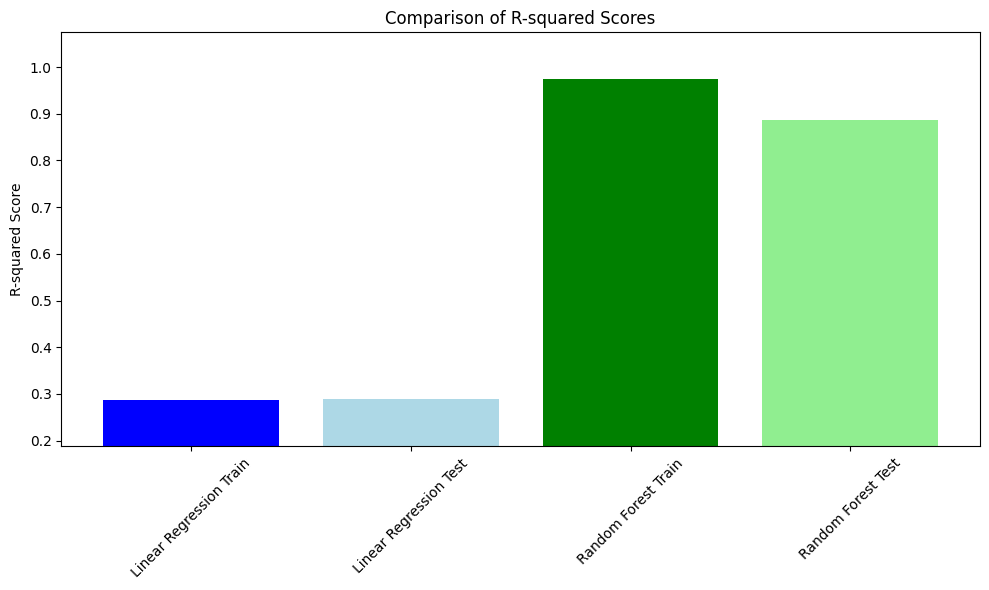

In [ ]:
# Plot comparison of R2 scores
labels = ['Linear Regression Train', 'Linear Regression Test', 'Random Forest Train', 'Random Forest Test']
r2_scores = [lr_train_r2, lr_test_r2, rf_train_r2, rf_test_r2]

plt.figure(figsize=(10, 6))
plt.bar(labels, r2_scores, color=['blue', 'lightblue', 'green', 'lightgreen'])
plt.title('Comparison of R-squared Scores')
plt.ylim(min(r2_scores) - 0.1, max(r2_scores) + 0.1)
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming you have the metrics already calculated and stored in variables

# Create a dictionary to hold the metrics
metrics_data = {
    "Model": ["Linear Regression", "Random Forest"],
    "Train MAE": [lr_train_mae, rf_train_mae],
    "Train MSE": [lr_train_mse, rf_train_mse],
    "Train RMSE": [lr_train_rmse, rf_train_rmse],
    "Train R2": [lr_train_r2, rf_train_r2],
    "Test MAE": [lr_test_mae, rf_test_mae],
    "Test MSE": [lr_test_mse, rf_test_mse],
    "Test RMSE": [lr_test_rmse, rf_test_rmse],
    "Test R2": [lr_test_r2, rf_test_r2]
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv('baseline_model_metrics.csv', index=False)

print("Metrics saved to model_metrics.csv")


Metrics saved to model_metrics.csv


###DEPLOYMENT

In [61]:
import joblib

# Save the model to a file
model_filename = 'rf_bestest_model.pkl'
joblib.dump(best_model, model_filename)
print(f"\nModel saved to {model_filename} successfully.")
# joblib.dump(label_encoders, 'label_encoders.pkl')
# joblib.dump(scaler, 'scaler.pkl')

# print("Model and preprocessing objects have been saved.")



Model saved to rf_bestest_model.pkl successfully.


###Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the deep learning model
def build_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build the model
model = build_model()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the training set
train_predictions = model.predict(X_train).flatten()
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_predictions)

print(f"Train Set Evaluation for Deep Learning Model:")
print(f"  MAE: {train_mae}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")
print(f"  R2: {train_r2}")

# Evaluate the model on the test set
test_predictions = model.predict(X_test).flatten()
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print(f"\nTest Set Evaluation for Deep Learning Model:")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R2: {test_r2}")

# Save the model
model.save('deep_learning_best_model.h5')
print("\nModel saved successfully.")


Epoch 1/100
12853/12853 [==============================] - 48s 4ms/step - loss: 4387.7603 - mae: 42.2407 - val_loss: 1693.0077 - val_mae: 31.7475
Epoch 2/100
12853/12853 [==============================] - 57s 4ms/step - loss: 1529.1101 - mae: 30.5481 - val_loss: 1387.1082 - val_mae: 29.2764
Epoch 3/100
12853/12853 [==============================] - 48s 4ms/step - loss: 1450.9960 - mae: 29.7308 - val_loss: 1374.6046 - val_mae: 28.4665
Epoch 4/100
12853/12853 [==============================] - 52s 4ms/step - loss: 1404.6433 - mae: 29.1913 - val_loss: 1387.5172 - val_mae: 29.3141
Epoch 5/100
12853/12853 [==============================] - 48s 4ms/step - loss: 1379.6680 - mae: 28.9283 - val_loss: 1808.2848 - val_mae: 32.5585
Epoch 6/100
12853/12853 [==============================] - 52s 4ms/step - loss: 1359.5818 - mae: 28.7237 - val_loss: 1534.6532 - val_mae: 31.3438
Epoch 7/100
12853/12853 [==============================] - 48s 4ms/step - loss: 1350.4370 - mae: 28.6180 - val_loss: 1374.07

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define the deep learning model
def build_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build the model
model = build_model()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Lists to store R2 scores
train_r2_scores = []
val_r2_scores = []

# Train the model and calculate R2 scores after each epoch
epochs = 100
batch_size = 32
validation_split = 0.2

for epoch in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, validation_split=validation_split, batch_size=batch_size, callbacks=[early_stopping], verbose=0)

    # Calculate R2 score for the training set
    train_predictions = model.predict(X_train).flatten()
    train_r2 = r2_score(y_train, train_predictions)
    train_r2_scores.append(train_r2)

    # Calculate R2 score for the validation set
    val_indices = int((1 - validation_split) * len(X_train))
    X_val = X_train[val_indices:]
    y_val = y_train[val_indices:]
    val_predictions = model.predict(X_val).flatten()
    val_r2 = r2_score(y_val, val_predictions)
    val_r2_scores.append(val_r2)

    # Early stopping check
    if early_stopping.stopped_epoch > 0:
        break

# Evaluate the model on the training set
train_predictions = model.predict(X_train).flatten()
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_predictions)

print(f"Train Set Evaluation for Deep Learning Model:")
print(f"  MAE: {train_mae}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")
print(f"  R2: {train_r2}")

# Evaluate the model on the test set
test_predictions = model.predict(X_test).flatten()
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print(f"\nTest Set Evaluation for Deep Learning Model:")
print(f"  MAE: {test_mae}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")
print(f"  R2: {test_r2}")

# Save the model
model.save('deep_learning_best_model.h5')
print("\nModel saved successfully.")

In [ ]:
# Plot the training and validation loss and R2 scores
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_range = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 6))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot for R2 Score
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_r2_scores, 'bo-', label='Training R2')
plt.plot(epochs_range, val_r2_scores, 'ro-', label='Validation R2')
plt.title('Training and Validation R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

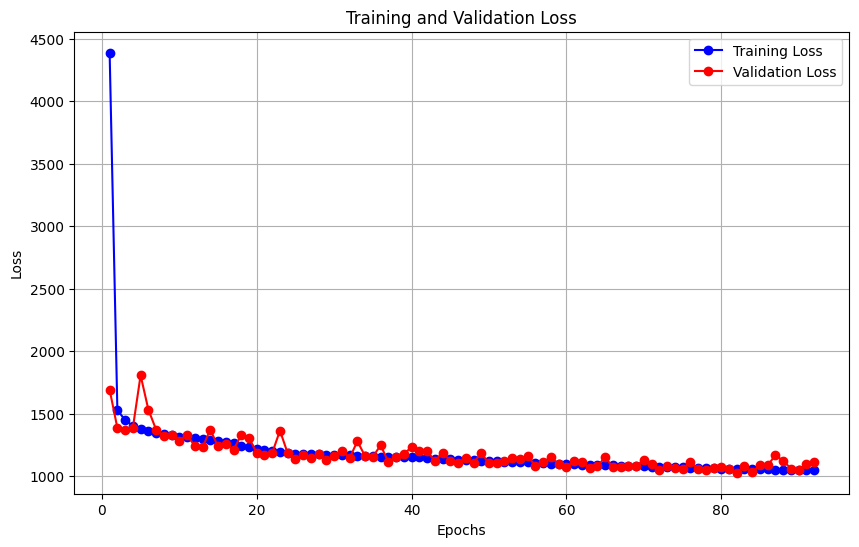

In [ ]:
import matplotlib.pyplot as plt

# Assume history is the object returned by the model.fit() method
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


###Deployemnt trial

In [ ]:
# Save the LabelEncoders using joblib
for feature, encoder in label_encoders.items():
    joblib.dump(encoder, f'{feature}_label_encoder.pkl')

In [ ]:
import joblib
# Save the preprocessing steps and the model
# Save the LabelEncoders using joblib
for feature, encoder in label_encoders.items():
    joblib.dump(encoder, f'{feature}_label_encoder.pkl')
joblib.dump(scaler, 'minmax_scaler.pkl')
joblib.dump(model, 'random_forest_model.pkl')


NameError: name 'label_encoder' is not defined

In [3]:
import joblib
import pandas as pd

# Load the preprocessing steps and the model
label_encoder = joblib.load('label_encoders.pkl')
minmax_scaler = joblib.load('scaler.pkl')
model = joblib.load('rf_bestest_model.pkl')

selected_features = ['RECORD_TYPE', 'STATE', 'GROUP_SIZE', 'HOMEOWNER', 'CAR_AGE', 'CAR_VALUE', 'RISK_FACTOR', 'MARRIED_COUPLE', 'AGE_OLDEST', 'C_PREVIOUS', 'DURATION_PREVIOUS', 'A','B', 'C', 'E', 'G']
categorical_columns = ['STATE', 'CAR_VALUE']
numerical_columns = ['CAR_AGE', 'AGE_OLDEST']

def preprocess_input(data):
    # Convert input data to DataFrame
    df = pd.DataFrame(data, index=[0])

    # Apply the same preprocessing as training data
    for col in categorical_columns:
        if col in label_encoder:
            df[col] = label_encoder[col].transform(df[col].astype(str))

    df[numerical_columns] = minmax_scaler.transform(df[numerical_columns])

    # Select the same features as training data
    df_selected = df[selected_features]

    return df_selected

def predict(data):
    preprocessed_data = preprocess_input(data)
    prediction = model.predict(preprocessed_data)
    rounded_prediction = round(prediction[0], 2)  # Round off to 2 decimal places
    return rounded_prediction

# Example usage
input_data = {
    'RECORD_TYPE': 1,
    'STATE': 'NY',
    'GROUP_SIZE': 2,
    'HOMEOWNER': 1,
    'CAR_AGE': 5,
    'CAR_VALUE': 'b',
    'RISK_FACTOR': 3,
    'MARRIED_COUPLE': 0,
    'AGE_OLDEST': 45,
    'C_PREVIOUS': 1,
    'DURATION_PREVIOUS': 2.5,
    'A': 0,
    'B': 1,
    'C': 1,
    'E': 0,
    'G': 1
}
print(predict(input_data))


690.12


In [10]:
# Example usage
input_data = {
    'RECORD_TYPE': 1,
    'GROUP_SIZE': 2,
    'HOMEOWNER': 1,
    'CAR_AGE': 5,
    'RISK_FACTOR': 3,
    'MARRIED_COUPLE': 0,
    'AGE_OLDEST': 45,
    'C_PREVIOUS': 1
}

In [11]:
# Create a boolean mask for the specified columns only
mask = pd.Series([True] * len(df))
for key, value in input_data.items():
    mask &= (df[key] == value)

# Extract rows that match the input data
matching_rows = df[mask]

matching_rows

,CUSTOMER_ID,SHOPPING_PT,RECORD_TYPE,DAY,TIME,STATE,LOCATION,GROUP_SIZE,HOMEOWNER,CAR_AGE,...,C_PREVIOUS,DURATION_PREVIOUS,A,B,C,D,E,F,G,COST
569990,10102976,11,1.0,2.0,12:46:00,31,10142.0,2.0,1.0,5.0,...,1.0,5.0,1.0,1.0,2.0,3.0,0.0,2.0,1.0,685


In [13]:
df['CAR_VALUE'].unique()

array([6, 4, 3, 5, 2, 7, 8, 1, 0])

In [15]:
matching_rows['AGE_OLDEST']

569990    45.0
Name: AGE_OLDEST, dtype: float64